In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines

In [2]:
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [3]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

In [4]:
#points array for grid interpolation
###creates 2770 vs 2 array of pairs of [u_g_cal,g_r_cal]
points = np.reshape((np.ravel([u_g_cal,g_r_cal],order='F')),(len(u_g_cal),2))

#x,y grid array for grid interpolation
###creates grid from [u_g_cal.min(),u_g_cal.max()]x[g_r_cal.min(),g_r_cal.max()] with 1000 increments
x_grid,y_grid = np.mgrid[(u_g_cal.min()):(u_g_cal.max()):1000j,(g_r_cal.min()):(g_r_cal.max()):1000j]

In [5]:
#use grid interpolation. points are data point coordinates
###feh_cal is the array of data values
###(x_grid,y_grid) are points at which to interpolate data
###method is method of interpolation:
#####nearest: return the value at the data point closest to the point of interpolation.
#####linear: tessellate the input point set to n-dimensional simplices, and interpolate linearly on each simplex
#####cubic: return the value determined from a cubic spline.
#create dictionary with keys nearest, linear, cubic that correspond to arrays of interpolated data
z_grid = {}
for i, method in enumerate(('nearest','linear','cubic')):
    key = method
    z_grid[key] = griddata(points,feh_cal,(x_grid,y_grid),method=method)
  
    

In [6]:
#use binned statistic 2d for original calibration sample
#creat dictionary with keys for original(z3), nearest(z0), linear(z1), and cubic(z2)
ret = {}
xedge = {}
yedge = {}
bin = {}

#original calibration
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)

#nearest interpolation
ret['nearest'],xedge['nearest'],yedge['nearest'],bin['nearest'] = stats.binned_statistic_2d(x_grid[:,0],y_grid[0,:],z_grid['nearest'][:,0],'median',50)

#linear interpolation
ret['linear'],xedge['linear'],yedge['linear'],bin['linear'] = stats.binned_statistic_2d(x_grid[np.isfinite(z_grid['linear'])],y_grid[np.isfinite(z_grid['linear'])],z_grid['linear'][np.isfinite(z_grid['linear'])],'median',50)

#cubic inerpolation
ret['cubic'],xedge['cubic'],yedge['cubic'],bin['cubic'] = stats.binned_statistic_2d(x_grid[np.isfinite(z_grid['cubic'])],y_grid[np.isfinite(z_grid['cubic'])],z_grid['cubic'][np.isfinite(z_grid['cubic'])],'median',50)


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [7]:
fields = [1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 68, 149, 150, 156, 176, 177, 178, 246]


In [8]:
#dictionaries & lists to be used in metallicity function
feh = {}
std = {}
metal = {}
error = {}
color = {}
initial_stars = []
cut_stars = []

for i, method in enumerate(('original','nearest','linear','cubic','nearest_regressor','ivezic','uerr','gerr','rerr')):
    metal[method] = []
    color[method] = []
    std[method] = []
    error[method] = []

In [9]:
def ivezic_equation(x,y):
    return ((-4.37) + (-8.56)*x + (15.5)*y + (-39.0)*x*y + (23.5)*x**2 + (20.5)*y**2 + (12.1)*(x**2)*y + (7.33)*x*(y**2) + (-10.1)*(x**3) + (-21.4)*y**3)


In [10]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    initial_stars.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.9)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    #weights to compute weighted average
    wt_uerr = 1/(uerr**2)
    wt_gerr = 1/(gerr**2)
    wt_rerr = 1/(rerr**2)
    wts = [wt_uerr,wt_gerr,wt_rerr]
    
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    cut_stars.append(len(u))
    stars = len(u)
    
    #original metallicity values from binned_statistic_sd from original calibration sample 
    ind, = np.where(((u_g)>=xedge['original'].min())&((u_g)<=xedge['original'].max())&((g_r)>=yedge['original'].min())&((g_r)<=yedge['original'].max()))
    ix = np.searchsorted(xedge['original'],(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge['original'],(g_r)[ind])
    iy = iy - 1
    feh = ret['original'][ix,iy]
    N = np.count_nonzero(~np.isnan(feh))
    #mean_metallicity['original'].append(np.nanmean(feh))
    print("metallicity for original method:",(np.nanmean(feh)))
    metal['original'].append(np.nanmedian(feh))
    std['original'].append(np.nanstd(feh))
    error['original'].append((np.nanstd(feh))/np.sqrt(N))
    
    #plot histograms for original method
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hist(feh[~np.isnan(feh)])
    ax.set_title('histogram of Fe/H original for field '+str(field_number[0]),fontsize=15)
    plt.show(block=False)
    
    #weighted averages computed using error in the u, g, and r bands
    for i, method in enumerate(('uerr','gerr','rerr')):
        wt = 1/(wts[i]**2)
        wt = wt[ind]
        selected = np.where((np.isnan(feh)!=True))
        feh = feh[selected]
        N = np.count_nonzero(~np.isnan(feh))
        wt = wt[selected]
        metal[method].append((np.sum(wt*feh))/(np.sum(wt)))
        std[method].append(np.nanstd(feh))
        error[method].append((np.nanstd(feh))/np.sqrt(N))
        print("weighted mean using "+str(method)+': ',((np.sum(wt*feh))/(np.sum(wt))))   

    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        N = np.count_nonzero(~np.isnan(feh))
        metal[method].append(np.nanmedian(feh))
        print("metallicity for "+method+" method:",(np.nanmean(feh)))
        std[method].append(np.nanstd(feh))
        error[method].append((np.nanstd(feh))/np.sqrt(N))
        
    #compute mean/median colors inside field, and then metallicity
    
    for i, method in enumerate(('original','nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        median_u_g = np.nanmedian(u_g[ind])
        median_g_r = np.nanmedian(g_r[ind])
        ix = np.searchsorted(xedge[method],median_u_g)
        ix = ix - 1
        iy = np.searchsorted(yedge[method],median_g_r)
        iy = iy - 1
        feh = ret[method][ix,iy]
        color[method].append(np.nanmedian(feh))
        print("color median Fe/H for "+method+" method:",(np.nanmedian(feh)))
        
    #use machine learning algorithm Nearest Neighbors
    ###The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.
    sample = np.reshape(np.ravel([u_g,g_r],order='F'),(len(u_g),2))   
    knn = neighbors.KNeighborsRegressor(5,weights='uniform')
    feh = knn.fit(points,feh_cal).predict(sample)
    metal['nearest_regressor'].append(np.nanmedian(feh))
    print("metallicity for nearest neighbor regression method:",(np.nanmean(feh)))
    std['nearest_regressor'].append(np.nanstd(feh))
    error['nearest_regressor'].append((np.nanstd(feh))/np.sqrt(stars))
    
    #use equation (4) from Ivezic et al. 2008 to estimate metallicity
    ### x=(u-g) for (g-r)<=0.4; x=(u-g)-2(g-r)+0.8 for (g-r)>0.4
    ### y=(g-r)
    feh = []
    x = u_g -(2*g_r) + 0.8
    index = np.arange(0,len(u_g))
    
    for i in index:
        feh.append([ivezic_equation(u_g[i],g_r[i]) if g_r[i] <= 0.4 else ivezic_equation(x[i],g_r[i])])
    #feh.append(ivezic_equation(u_g[i],g_r[i]))
    
    N = np.count_nonzero(~np.isnan(feh))
    metal['ivezic'].append(np.nanmedian(feh))
    std['ivezic'].append(np.nanstd(feh))
    error['ivezic'].append((np.nanstd(feh))/np.sqrt(N))
    print('mean metallicity for ivezic equation method: ',(np.nanmean(feh)))
    
    return 0


number of initial stars in field 1: 46634
number of stars after cuts in field 1: 2849
metallicity for original method: -1.1979015532135964


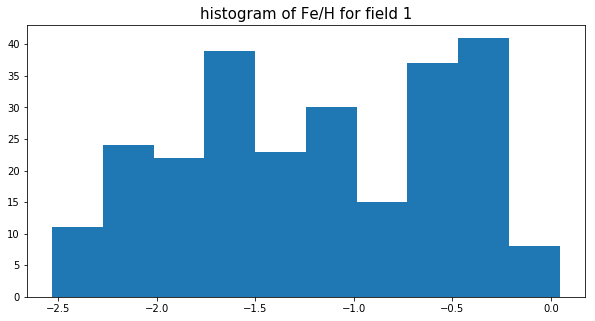

weighted mean using uerr:  -0.9239828911219762
weighted mean using gerr:  -1.4937749602417645
weighted mean using rerr:  -1.1723892892659067
metallicity for nearest method: -1.2540112091944768
metallicity for linear method: -1.311933441922211
metallicity for cubic method: -1.772713209358949
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.8211051798948004
color median Fe/H for cubic method: -2.408344682337285
metallicity for nearest neighbor regression method: -1.8376961
mean metallicity for ivezic equation method:  3.696527253139739


/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


number of initial stars in field 2: 61991
number of stars after cuts in field 2: 3435
metallicity for original method: -1.3346915160917907


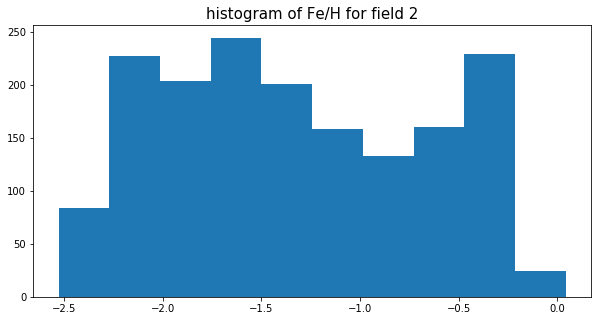

weighted mean using uerr:  -0.9289434889667549
weighted mean using gerr:  -1.3596072004451587
weighted mean using rerr:  -1.3570118782818312
metallicity for nearest method: -0.9029419451951981
metallicity for linear method: -1.4256130739987312
metallicity for cubic method: -1.9129858953913004
color median Fe/H for original method: -1.9125463962554932
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.5474763
mean metallicity for ivezic equation method:  -1.8805398460751919
number of initial stars in field 3: 847797
number of stars after cuts in field 3: 65489
metallicity for original method: -1.35108575487912


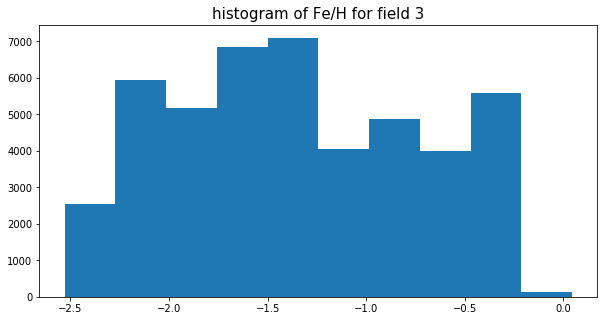

weighted mean using uerr:  -1.1931934746189727
weighted mean using gerr:  -1.4002647912514459
weighted mean using rerr:  -1.3502075468889039
metallicity for nearest method: -0.8831175419477725
metallicity for linear method: -1.4134289748157507
metallicity for cubic method: -1.5732140845912854
color median Fe/H for original method: -1.132754921913147
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.1726204685937023
color median Fe/H for cubic method: -1.1018151569994665
metallicity for nearest neighbor regression method: -1.4536854
mean metallicity for ivezic equation method:  -1.5882428915190623
number of initial stars in field 4: 640420
number of stars after cuts in field 4: 54416
metallicity for original method: -1.3743042049420737


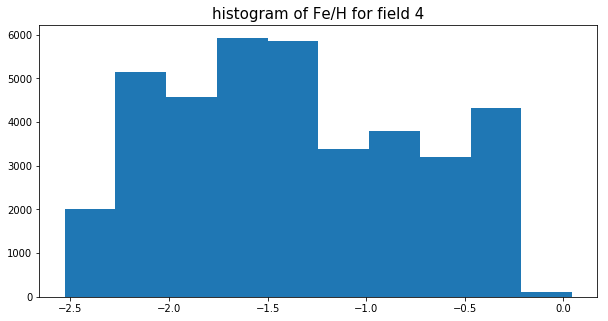

weighted mean using uerr:  -1.1899218043641144
weighted mean using gerr:  -1.530056160251902
weighted mean using rerr:  -2.1957768764739485
metallicity for nearest method: -0.9219196927853119
metallicity for linear method: -1.4403549476920423
metallicity for cubic method: -1.6174295875340776
color median Fe/H for original method: -1.132754921913147
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.1726204685937023
color median Fe/H for cubic method: -1.1018151569994665
metallicity for nearest neighbor regression method: -1.4911034
mean metallicity for ivezic equation method:  -1.6539135966339982
number of initial stars in field 5: 1048414
number of stars after cuts in field 5: 92611
metallicity for original method: -1.4395728897074516


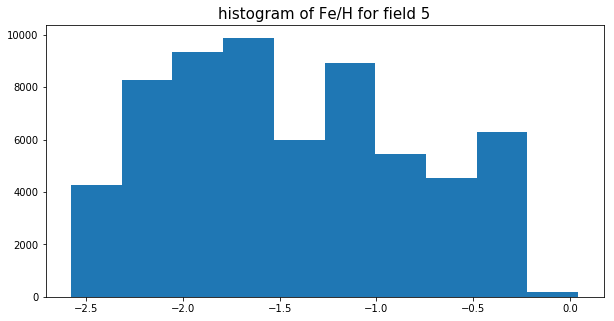

weighted mean using uerr:  -1.1338474785399342
weighted mean using gerr:  -1.5932581249792492
weighted mean using rerr:  -1.3152541731003111
metallicity for nearest method: -0.8712692490875951
metallicity for linear method: -1.5181885464306826
metallicity for cubic method: -1.75532572100304
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.587666
mean metallicity for ivezic equation method:  -1.7206909068385567
number of initial stars in field 7: 1201514
number of stars after cuts in field 7: 146618
metallicity for original method: -1.36376450476001


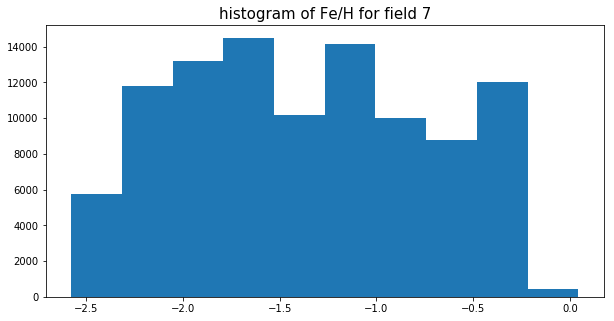

weighted mean using uerr:  -0.8561470879281884
weighted mean using gerr:  -0.6817284178208526
weighted mean using rerr:  -1.3238267214202972
metallicity for nearest method: -0.8797924542513471
metallicity for linear method: -1.427969181171544
metallicity for cubic method: -1.6245403509781489
color median Fe/H for original method: -1.132754921913147
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.1726204685937023
color median Fe/H for cubic method: -1.1018151569994665
metallicity for nearest neighbor regression method: -1.4792612
mean metallicity for ivezic equation method:  -1.6376736770850044
number of initial stars in field 8: 53873
number of stars after cuts in field 8: 625
metallicity for original method: -1.5288815854011841


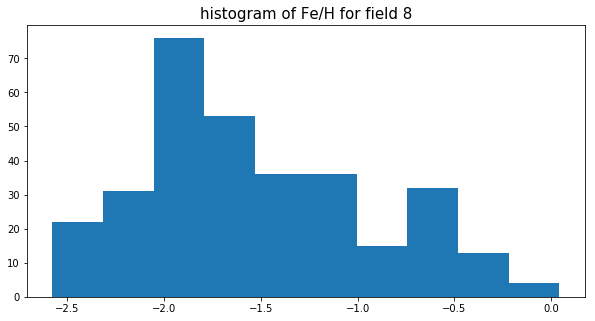

weighted mean using uerr:  -1.2760668565609994
weighted mean using gerr:  -1.5572400300770481
weighted mean using rerr:  -1.5810470078353858
metallicity for nearest method: -0.9637516021728516
metallicity for linear method: -1.603946844151679
metallicity for cubic method: -2.092319509482136
color median Fe/H for original method: -2.5291123390197754
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.271069247157712
color median Fe/H for cubic method: -2.311403819188303
metallicity for nearest neighbor regression method: -1.7575822
mean metallicity for ivezic equation method:  -1.8629753502125732
number of initial stars in field 9: 723837
number of stars after cuts in field 9: 75346
metallicity for original method: -1.4251820191119817


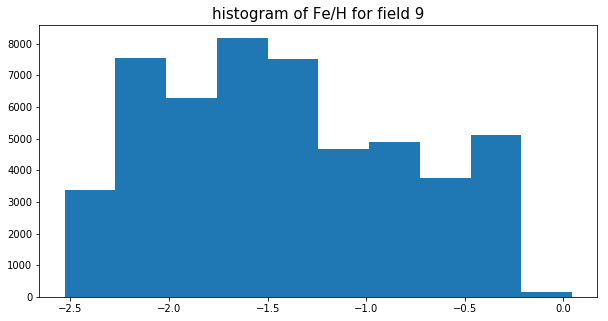

weighted mean using uerr:  -1.250695219647449
weighted mean using gerr:  -1.4258842190007688
weighted mean using rerr:  -1.2811334646022479
metallicity for nearest method: -0.9000215189797538
metallicity for linear method: -1.5099327261419992
metallicity for cubic method: -1.7278720374503538
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.5764071
mean metallicity for ivezic equation method:  -1.7465791617504602
number of initial stars in field 12: 515707
number of stars after cuts in field 12: 64007
metallicity for original method: -1.4174953633367169


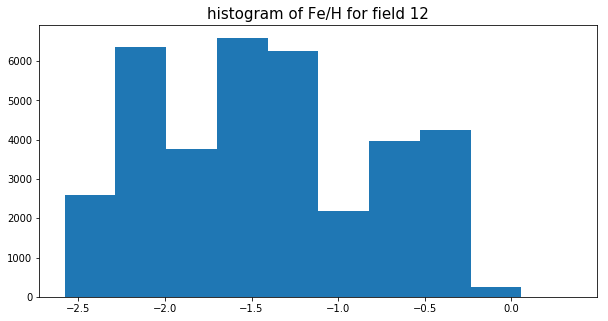

weighted mean using uerr:  -1.4861101149026537
weighted mean using gerr:  -1.40265456672922
weighted mean using rerr:  -1.1420490376977344
metallicity for nearest method: -0.8552708136264816
metallicity for linear method: -1.5124309637139155
metallicity for cubic method: -1.9015073633697497
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.6095861
mean metallicity for ivezic equation method:  -1.7437021268309392
number of initial stars in field 13: 80790
number of stars after cuts in field 13: 4344
metallicity for original method: -1.402487589728392


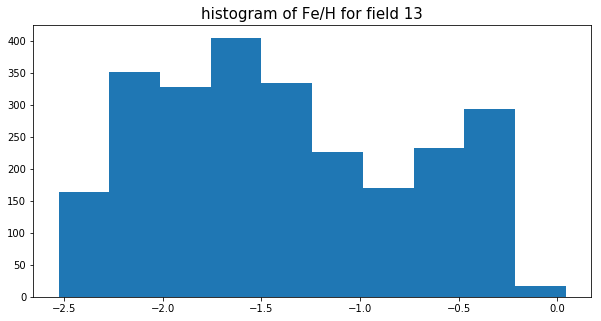

weighted mean using uerr:  -1.176479804077504
weighted mean using gerr:  -1.4041436563622243
weighted mean using rerr:  -1.3390199307198865
metallicity for nearest method: -0.8820301194985708
metallicity for linear method: -1.4710946755158762
metallicity for cubic method: -1.8905559840424022
color median Fe/H for original method: -1.9125463962554932
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9150277003104201
color median Fe/H for cubic method: -1.8688022871453192
metallicity for nearest neighbor regression method: -1.574589
mean metallicity for ivezic equation method:  -1.7634766693265416
number of initial stars in field 14: 776768
number of stars after cuts in field 14: 85748
metallicity for original method: -1.418008371895485


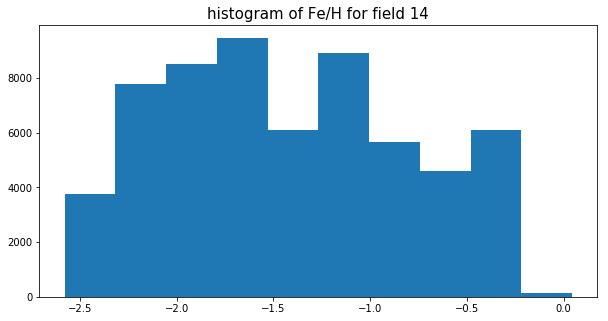

weighted mean using uerr:  -1.3576441640145105
weighted mean using gerr:  -1.4229064594390308
weighted mean using rerr:  -1.032790976735841
metallicity for nearest method: -0.8545645975872226
metallicity for linear method: -1.4947916411362585
metallicity for cubic method: -1.6895067489986746
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.5553896
mean metallicity for ivezic equation method:  -1.7029202319466314
number of initial stars in field 15: 755871
number of stars after cuts in field 15: 66660
metallicity for original method: -1.3754378535805696


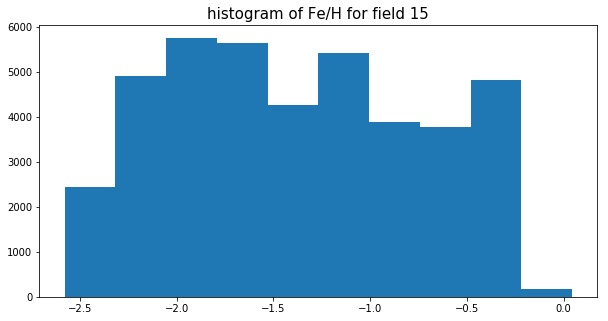

weighted mean using uerr:  -1.2346900917585952
weighted mean using gerr:  -1.3790920274582645
weighted mean using rerr:  -1.517676603974692
metallicity for nearest method: -0.9493688110028047
metallicity for linear method: -1.4558435285244287
metallicity for cubic method: -1.7579899522792026
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.5395875
mean metallicity for ivezic equation method:  -1.7593215218662213
number of initial stars in field 16: 402062
number of stars after cuts in field 16: 40929
metallicity for original method: -1.425718670038672


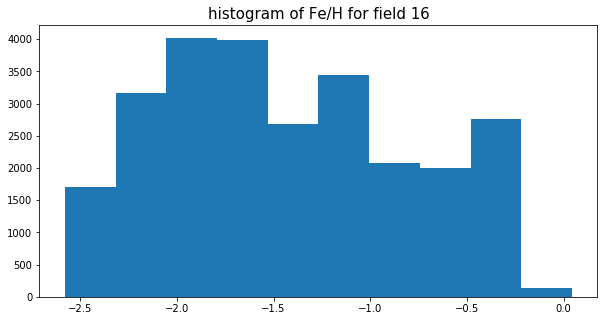

weighted mean using uerr:  -1.230373123425112
weighted mean using gerr:  -1.4269554510318916
weighted mean using rerr:  -1.5422893402687223
metallicity for nearest method: -0.8711289193249008
metallicity for linear method: -1.5040279048950072
metallicity for cubic method: -1.828062505279903
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.5865237
mean metallicity for ivezic equation method:  -1.7514335615280845
number of initial stars in field 18: 77413
number of stars after cuts in field 18: 5585
metallicity for original method: -1.410409258909321


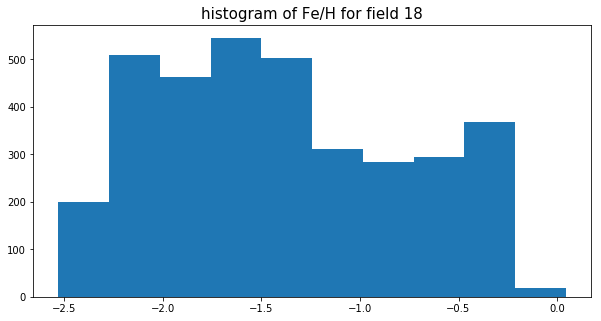

weighted mean using uerr:  -0.8240659913132052
weighted mean using gerr:  -1.2031455616704108
weighted mean using rerr:  -1.412643204317227
metallicity for nearest method: -1.0119998015855487
metallicity for linear method: -1.4923016791752084
metallicity for cubic method: -1.7892670231728847
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.5690124
mean metallicity for ivezic equation method:  -1.6236239768289686
number of initial stars in field 19: 43871
number of stars after cuts in field 19: 2830
metallicity for original method: -1.4177740116154625


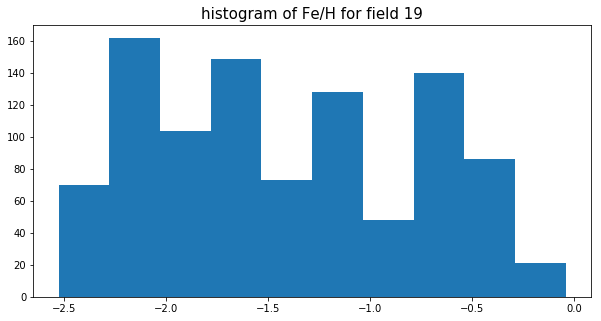

weighted mean using uerr:  -1.4126690238574366
weighted mean using gerr:  -1.395371366062847
weighted mean using rerr:  -1.9119833240459372
metallicity for nearest method: -1.4351956892013549
metallicity for linear method: -1.5552431933462263
metallicity for cubic method: -2.193813710724248
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.058466703132809
color median Fe/H for cubic method: -1.7391755324175593
metallicity for nearest neighbor regression method: -1.7258085
mean metallicity for ivezic equation method:  -2.3340459249599683
number of initial stars in field 20: 42362
number of stars after cuts in field 20: 379
metallicity for original method: -1.6994287712233407


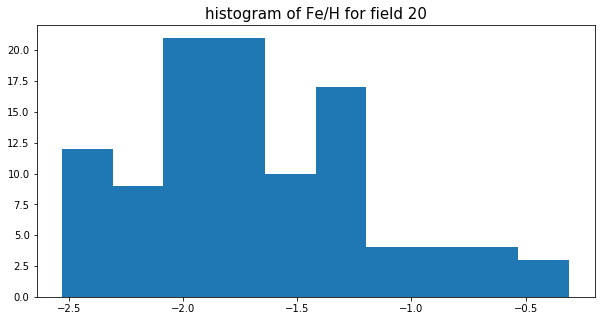

weighted mean using uerr:  -1.2195088914404353
weighted mean using gerr:  -1.6791463337944672
weighted mean using rerr:  -1.6971356207420092
metallicity for nearest method: -2.3399723768234253
metallicity for linear method: -1.781359093449868
metallicity for cubic method: -2.76167894392785
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9964266451947972
color median Fe/H for cubic method: -8.970822892945096
metallicity for nearest neighbor regression method: -1.9555635
mean metallicity for ivezic equation method:  -2.3968440696585604
number of initial stars in field 21: 46188
number of stars after cuts in field 21: 551
metallicity for original method: -1.3518786230124533


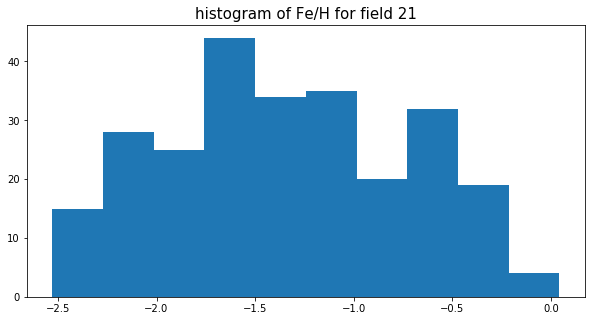

weighted mean using uerr:  -1.074602791430394
weighted mean using gerr:  -1.3192585784910733
weighted mean using rerr:  -1.2984693668802447
metallicity for nearest method: -1.1405627727508545
metallicity for linear method: -1.3941383475415483
metallicity for cubic method: -1.8156568885892739
color median Fe/H for original method: -1.824390172958374
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.8671866534121997
color median Fe/H for cubic method: -1.9607130425756147
metallicity for nearest neighbor regression method: -1.5274379
mean metallicity for ivezic equation method:  -1.8831868630304986
number of initial stars in field 22: 59954
number of stars after cuts in field 22: 755
metallicity for original method: -1.7085853449974682


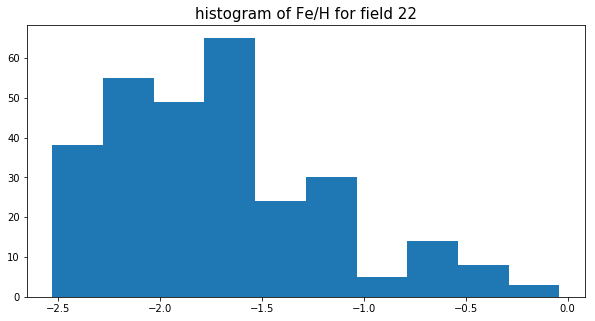

weighted mean using uerr:  -1.4734954032938403
weighted mean using gerr:  -1.7297052954955543
weighted mean using rerr:  -1.753939912632608
metallicity for nearest method: -0.7632036209106445
metallicity for linear method: -1.7991365680260727
metallicity for cubic method: -2.7285268960915503
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.0691107833477527
color median Fe/H for cubic method: -2.232255044483944
metallicity for nearest neighbor regression method: -1.9346437
mean metallicity for ivezic equation method:  -2.2348569113664865
number of initial stars in field 24: 29599
number of stars after cuts in field 24: 560
metallicity for original method: -1.3867831784783557


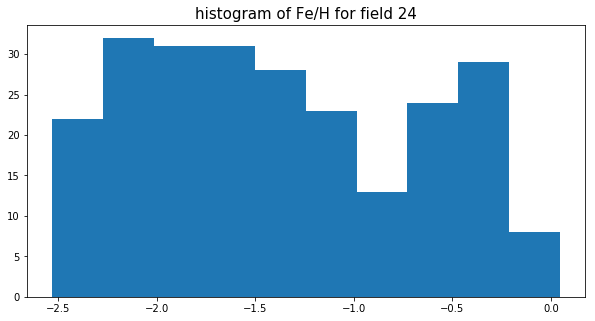

weighted mean using uerr:  -1.0558495257710216
weighted mean using gerr:  -1.3736182703106496
weighted mean using rerr:  -1.4390216020417306
metallicity for nearest method: -0.8392781344327059
metallicity for linear method: -1.4235292490867613
metallicity for cubic method: -1.9312137720210145
color median Fe/H for original method: -2.005466938018799
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9809728105668718
color median Fe/H for cubic method: -1.9362052010283806
metallicity for nearest neighbor regression method: -1.612739
mean metallicity for ivezic equation method:  -1.9432520322806
number of initial stars in field 26: 52301
number of stars after cuts in field 26: 3767
metallicity for original method: -1.31284201884011


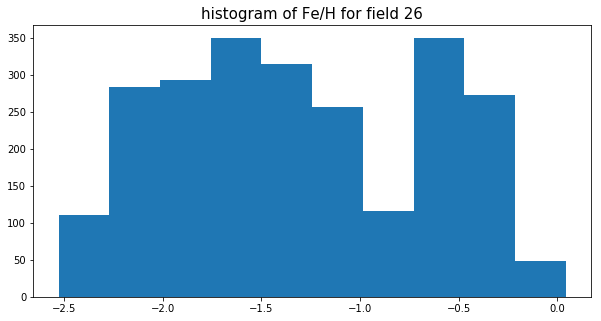

weighted mean using uerr:  -1.2649437821191671
weighted mean using gerr:  -1.3312614800853517
weighted mean using rerr:  -1.3240721860505942
metallicity for nearest method: -0.9859796489577696
metallicity for linear method: -1.3384864596638966
metallicity for cubic method: -1.7199255715569752
color median Fe/H for original method: -1.5431206226348877
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.5128520483966148
color median Fe/H for cubic method: -1.5025171636863859
metallicity for nearest neighbor regression method: -1.4807949
mean metallicity for ivezic equation method:  -1.6401901271283987
number of initial stars in field 27: 94878
number of stars after cuts in field 27: 13883
metallicity for original method: -1.355154563542611


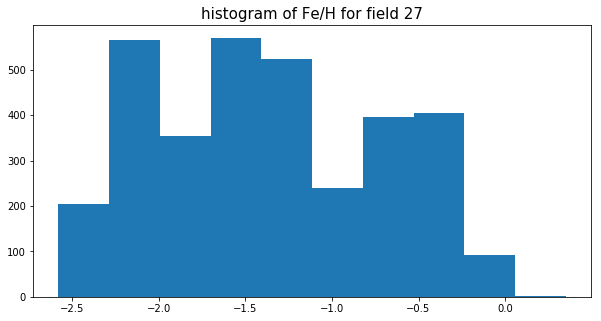

weighted mean using uerr:  -1.076183688502686
weighted mean using gerr:  -1.3695933552991766
weighted mean using rerr:  -0.9126189880258435
metallicity for nearest method: -1.0234013085954645
metallicity for linear method: -1.4230562881723772
metallicity for cubic method: -2.1415859571319995
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9964266451947972
color median Fe/H for cubic method: -8.970822892945096
metallicity for nearest neighbor regression method: -1.6893781
mean metallicity for ivezic equation method:  -2.063266746708861
number of initial stars in field 28: 114705
number of stars after cuts in field 28: 13946
metallicity for original method: -1.3223870159925815


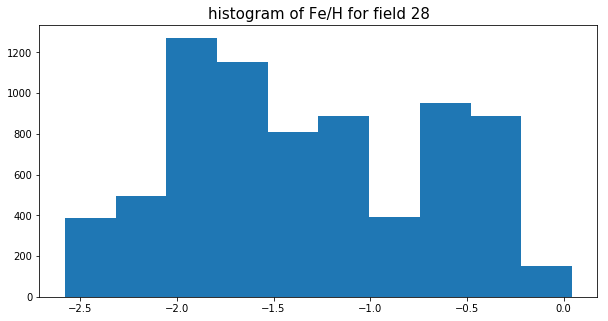

weighted mean using uerr:  -1.0763222987519803
weighted mean using gerr:  -0.9048580331904084
weighted mean using rerr:  -1.3086657810390643
metallicity for nearest method: -0.9655596953404101
metallicity for linear method: -1.3733006513178803
metallicity for cubic method: -1.8751459329807039
color median Fe/H for original method: -1.824390172958374
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.8671866534121997
color median Fe/H for cubic method: -1.9607130425756147
metallicity for nearest neighbor regression method: -1.5264348
mean metallicity for ivezic equation method:  -1.7162652913587861
number of initial stars in field 29: 404098
number of stars after cuts in field 29: 67384
metallicity for original method: -1.3723416384396308


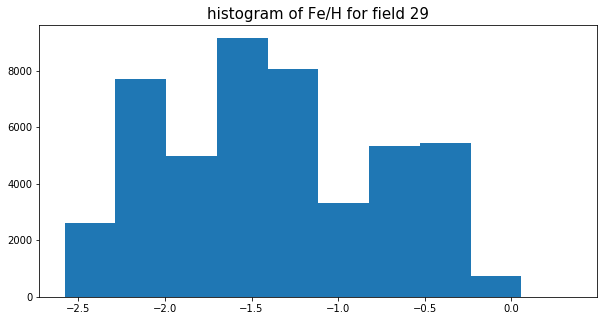

weighted mean using uerr:  -0.5629602777210351
weighted mean using gerr:  -1.4570515736858491
weighted mean using rerr:  -1.370249677445884
metallicity for nearest method: -0.92658173504761
metallicity for linear method: -1.408017423204801
metallicity for cubic method: -1.7251409632244894
color median Fe/H for original method: -1.572399616241455
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.4952628495812663
color median Fe/H for cubic method: -1.5635008877999843
metallicity for nearest neighbor regression method: -1.4986842
mean metallicity for ivezic equation method:  -1.5043672975718159
number of initial stars in field 30: 1551563
number of stars after cuts in field 30: 45449
metallicity for original method: -1.3349823418501037


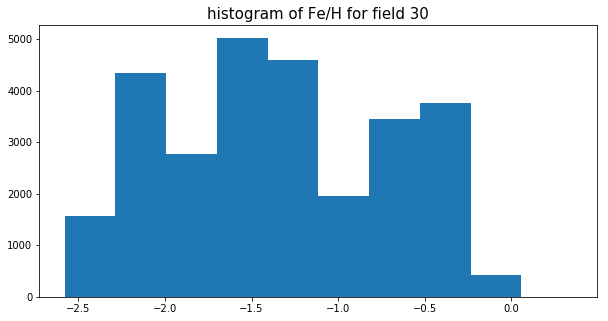

weighted mean using uerr:  -1.2538488560244931
weighted mean using gerr:  -1.3318173950096919
weighted mean using rerr:  -1.3334013126939936
metallicity for nearest method: -0.8865506603444366
metallicity for linear method: -1.3810526632452724
metallicity for cubic method: -1.7526043141622172
color median Fe/H for original method: -1.572399616241455
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.4952628495812663
color median Fe/H for cubic method: -1.5635008877999843
metallicity for nearest neighbor regression method: -1.5052394
mean metallicity for ivezic equation method:  -1.625255025301829
number of initial stars in field 31: 46943
number of stars after cuts in field 31: 1132
metallicity for original method: -1.4359631357486553


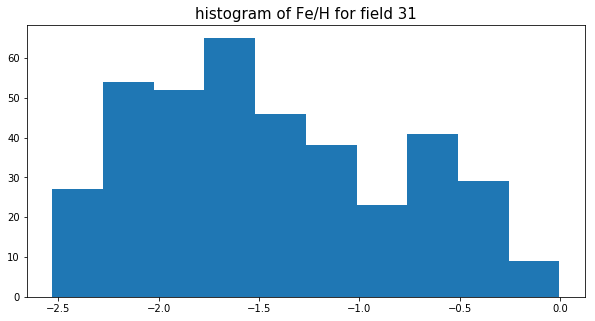

weighted mean using uerr:  -0.865580944113824
weighted mean using gerr:  -1.4275516973026066
weighted mean using rerr:  -1.431790418754957
metallicity for nearest method: -0.9244871480124337
metallicity for linear method: -1.4782793575445625
metallicity for cubic method: -2.1371375491227558
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.0691107833477527
color median Fe/H for cubic method: -2.232255044483944
metallicity for nearest neighbor regression method: -1.7072756
mean metallicity for ivezic equation method:  -1.9983243119415681
number of initial stars in field 32: 1825281
number of stars after cuts in field 32: 152476
metallicity for original method: -1.2579174814216574


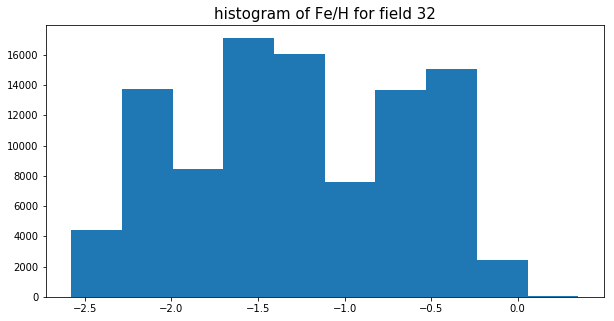

weighted mean using uerr:  -1.0190115823993562
weighted mean using gerr:  -1.2800655875707312
weighted mean using rerr:  -0.7968662734275118
metallicity for nearest method: -0.9320448755125248
metallicity for linear method: -1.2801008426977198
metallicity for cubic method: -1.554577471260673
color median Fe/H for original method: -1.572399616241455
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.4952628495812663
color median Fe/H for cubic method: -1.5635008877999843
metallicity for nearest neighbor regression method: -1.3636072
mean metallicity for ivezic equation method:  -1.4977489083457314
number of initial stars in field 33: 45996
number of stars after cuts in field 33: 1105
metallicity for original method: -1.3179028308758998


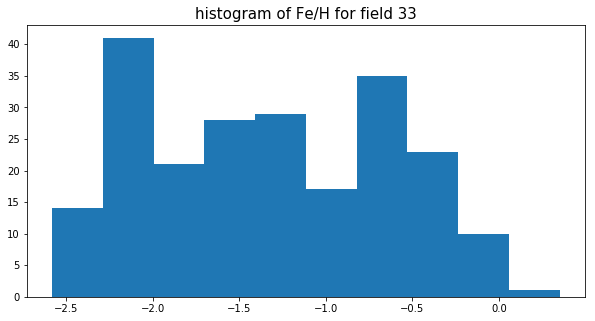

weighted mean using uerr:  -0.9505789217966764
weighted mean using gerr:  -1.2477438201789526
weighted mean using rerr:  -1.2837514242697545
metallicity for nearest method: -0.905979851881663
metallicity for linear method: -1.3760508524700397
metallicity for cubic method: -2.141882394101959
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: nan
color median Fe/H for cubic method: nan
metallicity for nearest neighbor regression method: -1.7245356
mean metallicity for ivezic equation method:  -1.4725563885000579
number of initial stars in field 34: 1421909
number of stars after cuts in field 34: 190149
metallicity for original method: -1.4102051520320158


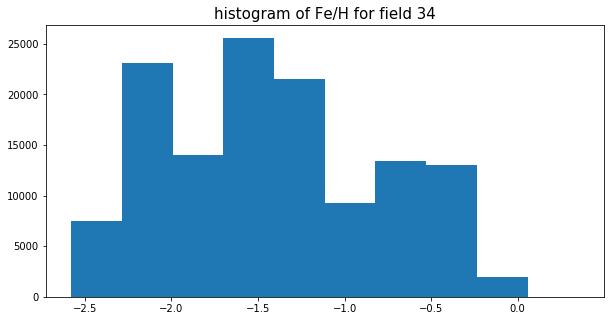

weighted mean using uerr:  -1.1958647924731474
weighted mean using gerr:  -1.18826108805673
weighted mean using rerr:  -1.0482376494887444
metallicity for nearest method: -0.9435295383528908
metallicity for linear method: -1.4546469320447077
metallicity for cubic method: -1.817649723977939
color median Fe/H for original method: -1.5431206226348877
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.5128520483966148
color median Fe/H for cubic method: -1.5025171636863859
metallicity for nearest neighbor regression method: -1.5683641
mean metallicity for ivezic equation method:  -1.6461374301046277
number of initial stars in field 35: 1606580
number of stars after cuts in field 35: 27253
metallicity for original method: -1.1714805520256524


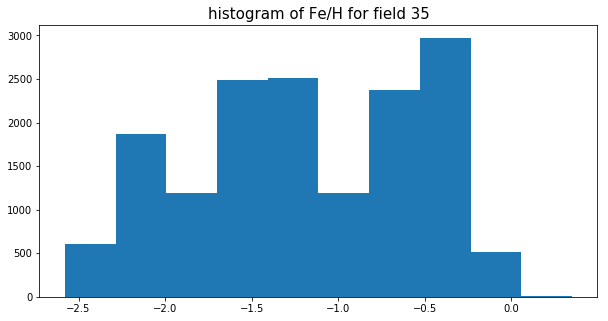

weighted mean using uerr:  -0.40851264377847674
weighted mean using gerr:  -1.2436001683791231
weighted mean using rerr:  -1.1317044211466134
metallicity for nearest method: -0.9552534205733605
metallicity for linear method: -1.165237859296871
metallicity for cubic method: -1.3443969235561257
color median Fe/H for original method: -1.447492003440857
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.1436360954911318
color median Fe/H for cubic method: -1.1078426046405707
metallicity for nearest neighbor regression method: -1.1923856
mean metallicity for ivezic equation method:  -1.2861508332080391
number of initial stars in field 37: 1743130
number of stars after cuts in field 37: 145725
metallicity for original method: -1.2540464895093544


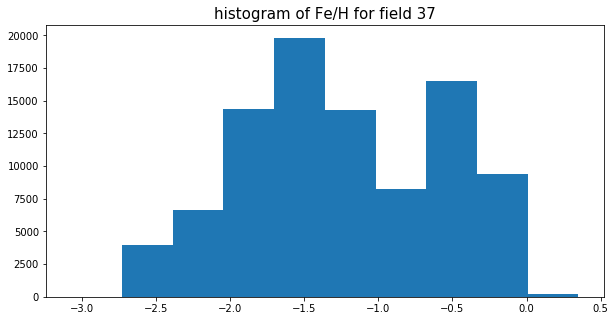

weighted mean using uerr:  -1.0021506740575303
weighted mean using gerr:  -1.3482331584331058
weighted mean using rerr:  -1.263521262306866
metallicity for nearest method: -0.9635165143640566
metallicity for linear method: -1.2680904226412075
metallicity for cubic method: -1.557158423240204
color median Fe/H for original method: -1.572399616241455
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.4952628495812663
color median Fe/H for cubic method: -1.5635008877999843
metallicity for nearest neighbor regression method: -1.3574506
mean metallicity for ivezic equation method:  -1.4918761512820793
number of initial stars in field 40: 1752944
number of stars after cuts in field 40: 315218
metallicity for original method: -1.2510206897368523


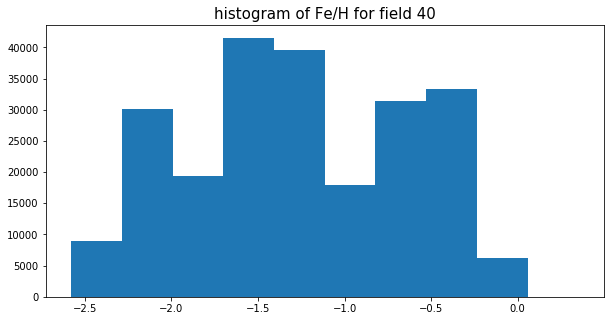

weighted mean using uerr:  -1.0652371250045538
weighted mean using gerr:  -1.6246004173970234
weighted mean using rerr:  -1.5447804417901243
metallicity for nearest method: -0.9619193351021152
metallicity for linear method: -1.2518686191242183
metallicity for cubic method: -1.464740994122652
color median Fe/H for original method: -1.3767668008804321
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.360867236584736
color median Fe/H for cubic method: -1.3282077626090083
metallicity for nearest neighbor regression method: -1.3192463
mean metallicity for ivezic equation method:  -1.4346237822692975
number of initial stars in field 42: 1882163
number of stars after cuts in field 42: 89953
metallicity for original method: -1.1590312999968768


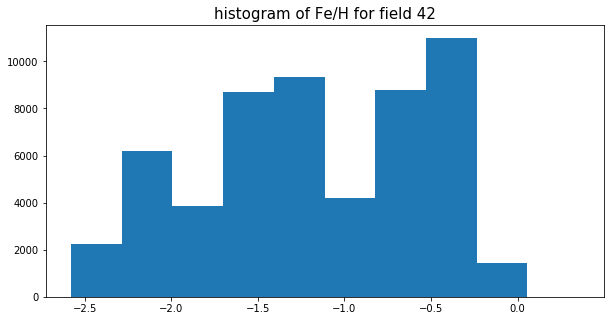

weighted mean using uerr:  -0.8901171805099043
weighted mean using gerr:  -1.1752966022107822
weighted mean using rerr:  -1.15682378551599
metallicity for nearest method: -0.904685682837471
metallicity for linear method: -1.1622943260607503
metallicity for cubic method: -1.3046906821364734
color median Fe/H for original method: -1.447492003440857
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.1436360954911318
color median Fe/H for cubic method: -1.1078426046405707
metallicity for nearest neighbor regression method: -1.1811115
mean metallicity for ivezic equation method:  -1.2181825686206231
number of initial stars in field 44: 427557
number of stars after cuts in field 44: 61749
metallicity for original method: -1.6501482733076875


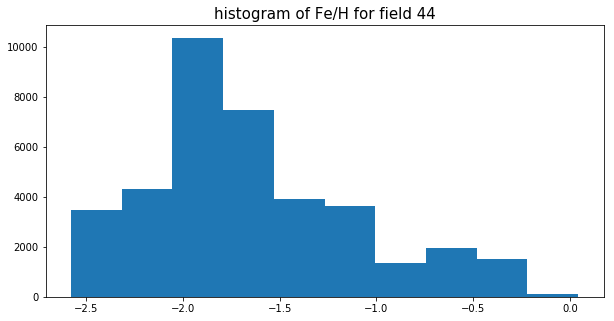

weighted mean using uerr:  -1.4103343094747756
weighted mean using gerr:  -1.6370172426673935
weighted mean using rerr:  -1.6077275076061806
metallicity for nearest method: -0.9752753176083222
metallicity for linear method: -1.7209034645165249
metallicity for cubic method: -2.3058755052575406
color median Fe/H for original method: -2.005466938018799
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9809728105668718
color median Fe/H for cubic method: -1.9362052010283806
metallicity for nearest neighbor regression method: -1.8502816
mean metallicity for ivezic equation method:  -1.9417164964032492
number of initial stars in field 46: 1304849
number of stars after cuts in field 46: 240939
metallicity for original method: -1.3652391012009564


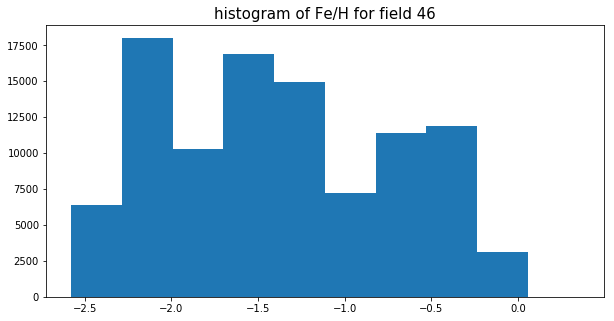

weighted mean using uerr:  -1.1914288965684332
weighted mean using gerr:  -1.36393031373963
weighted mean using rerr:  -1.3600471177409186
metallicity for nearest method: -1.0075838471023288
metallicity for linear method: -1.4231574590987837
metallicity for cubic method: -2.0776044088878796
color median Fe/H for original method: -2.005466938018799
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9809728105668718
color median Fe/H for cubic method: -1.9362052010283806
metallicity for nearest neighbor regression method: -1.6200382
mean metallicity for ivezic equation method:  -1.657731512292917
number of initial stars in field 48: 2145968
number of stars after cuts in field 48: 130840
metallicity for original method: -1.2125885372608025


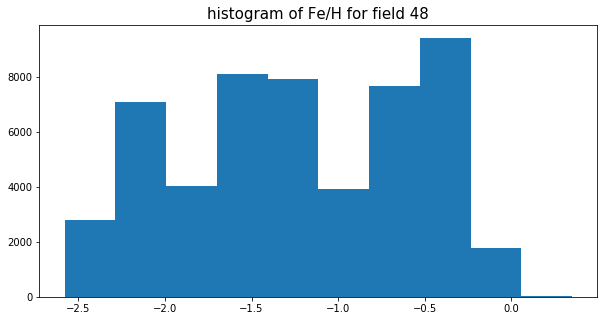

weighted mean using uerr:  -1.2289174618635854
weighted mean using gerr:  -0.957834932130949
weighted mean using rerr:  -0.9916845292421594
metallicity for nearest method: -0.9389391324683386
metallicity for linear method: -1.2269118079823071
metallicity for cubic method: -1.5004678052499587
color median Fe/H for original method: -1.447492003440857
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.1436360954911318
color median Fe/H for cubic method: -1.1078426046405707
metallicity for nearest neighbor regression method: -1.2154413
mean metallicity for ivezic equation method:  -1.8420528820490512
number of initial stars in field 49: 1763774
number of stars after cuts in field 49: 250502
metallicity for original method: -1.2269339727135553


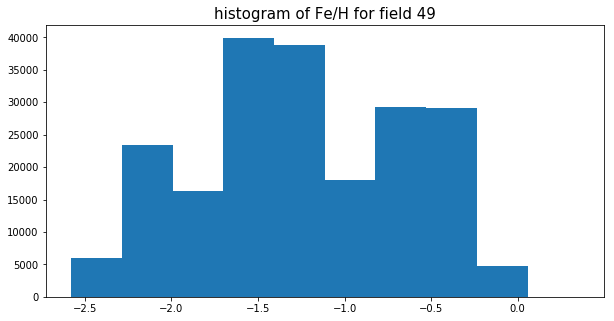

weighted mean using uerr:  -1.03350702706987
weighted mean using gerr:  -1.1541065453083044
weighted mean using rerr:  -0.9334178023366592
metallicity for nearest method: -0.9717997052248379
metallicity for linear method: -1.2048750065254095
metallicity for cubic method: -1.315154087274452
color median Fe/H for original method: -1.3767668008804321
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.360867236584736
color median Fe/H for cubic method: -1.3282077626090083
metallicity for nearest neighbor regression method: -1.2480009
mean metallicity for ivezic equation method:  -1.3408086403311648
number of initial stars in field 50: 1155082


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal


number of stars after cuts in field 50: 223
metallicity for original method: -1.132754921913147


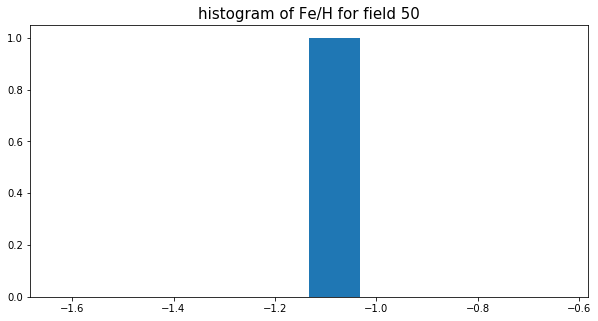

weighted mean using uerr:  -1.132754921913147
weighted mean using gerr:  -1.132754921913147
weighted mean using rerr:  -1.132754921913147
metallicity for nearest method: nan
metallicity for linear method: -1.5511666465983662
metallicity for cubic method: -2.523232251219853
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: nan
color median Fe/H for cubic method: nan
metallicity for nearest neighbor regression method: -2.1491137
mean metallicity for ivezic equation method:  7.612548223910407


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


number of initial stars in field 51: 1574573
number of stars after cuts in field 51: 210235
metallicity for original method: -1.2986248185849176


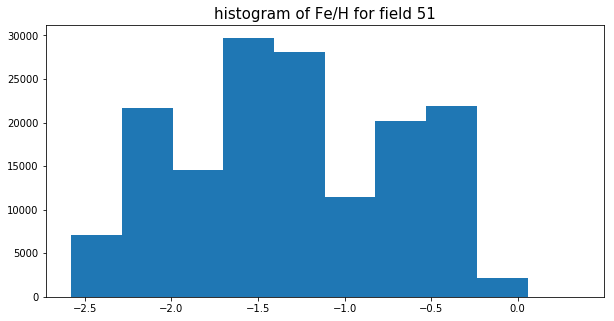

weighted mean using uerr:  -1.1266977544859067
weighted mean using gerr:  -1.2778205362792294
weighted mean using rerr:  -1.3006399429325408
metallicity for nearest method: -0.8802451669106579
metallicity for linear method: -1.3205885241736157
metallicity for cubic method: -1.5238680166169205
color median Fe/H for original method: -1.572399616241455
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.4952628495812663
color median Fe/H for cubic method: -1.5635008877999843
metallicity for nearest neighbor regression method: -1.3887589
mean metallicity for ivezic equation method:  -1.5196064723347942
number of initial stars in field 52: 62890
number of stars after cuts in field 52: 1949
metallicity for original method: -1.5938341460908143


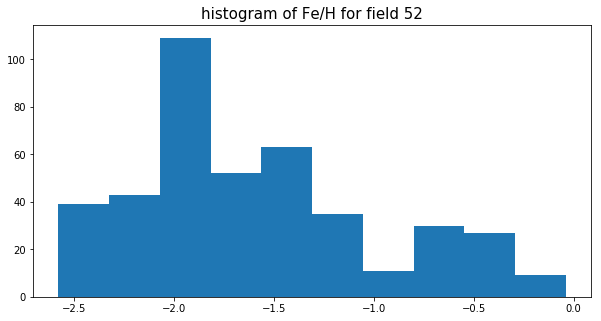

weighted mean using uerr:  -1.390928849118974
weighted mean using gerr:  -1.5622044153197514
weighted mean using rerr:  -1.5945101627461467
metallicity for nearest method: -1.264573574066162
metallicity for linear method: -1.7105566148495528
metallicity for cubic method: -3.154294954442442
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: nan
color median Fe/H for cubic method: nan
metallicity for nearest neighbor regression method: -1.9189793
mean metallicity for ivezic equation method:  -2.2035239692581863
number of initial stars in field 53: 396092
number of stars after cuts in field 53: 104288
metallicity for original method: -1.4034762050075122


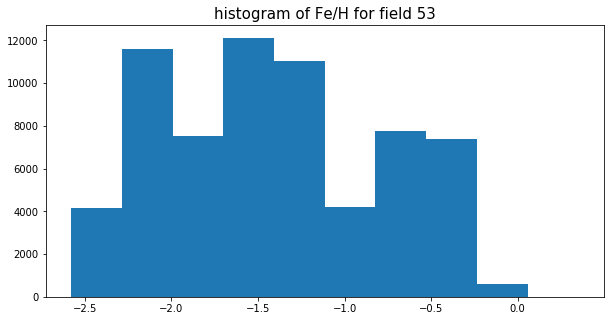

weighted mean using uerr:  -1.2006747327397538
weighted mean using gerr:  -1.3903728657406489
weighted mean using rerr:  -1.515162358548039
metallicity for nearest method: -0.9883622757600056
metallicity for linear method: -1.4399455985921417
metallicity for cubic method: -1.7625195076983762
color median Fe/H for original method: -1.9125463962554932
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9150277003104201
color median Fe/H for cubic method: -1.8688022871453192
metallicity for nearest neighbor regression method: -1.5335214
mean metallicity for ivezic equation method:  -1.634406067674985
number of initial stars in field 54: 163332
number of stars after cuts in field 54: 19381
metallicity for original method: -1.4403316883501527


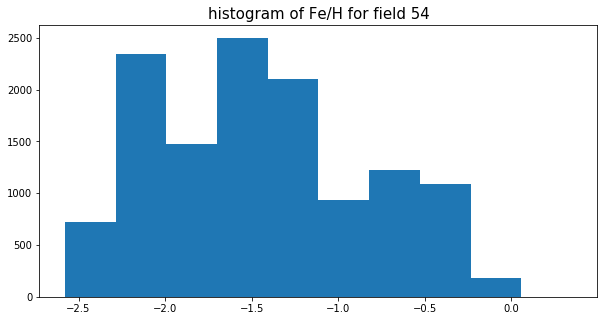

weighted mean using uerr:  -1.1839036342601879
weighted mean using gerr:  -1.4431665372759914
weighted mean using rerr:  -1.5968219420217662
metallicity for nearest method: -0.9752243471817231
metallicity for linear method: -1.4882405970633452
metallicity for cubic method: -1.9476015316478221
color median Fe/H for original method: -1.824390172958374
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.8671866534121997
color median Fe/H for cubic method: -1.9607130425756147
metallicity for nearest neighbor regression method: -1.6143179
mean metallicity for ivezic equation method:  -1.686011647253333
number of initial stars in field 55: 637616
number of stars after cuts in field 55: 106127
metallicity for original method: -1.3799247592325863


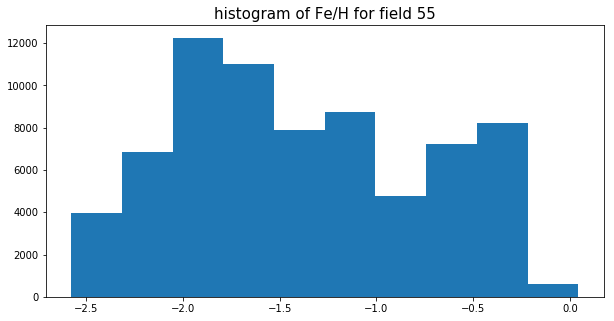

weighted mean using uerr:  -1.2283220274884434
weighted mean using gerr:  -1.395397497329782
weighted mean using rerr:  -1.5903152934813527
metallicity for nearest method: -0.8620591163635254
metallicity for linear method: -1.4315051140119253
metallicity for cubic method: -1.8033727235021901
color median Fe/H for original method: -1.572399616241455
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.4952628495812663
color median Fe/H for cubic method: -1.5635008877999843
metallicity for nearest neighbor regression method: -1.5416658
mean metallicity for ivezic equation method:  -1.699386983211693
number of initial stars in field 56: 120917
number of stars after cuts in field 56: 6302
metallicity for original method: -1.8160888075482684


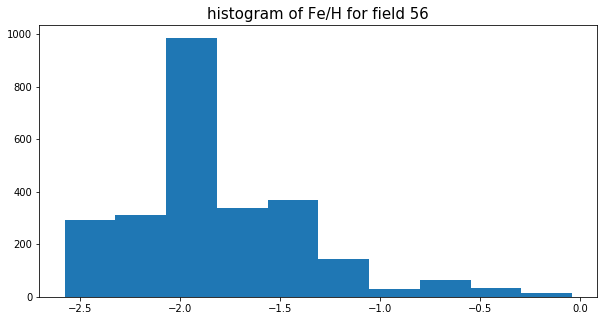

weighted mean using uerr:  -1.572708227835684
weighted mean using gerr:  -1.824283409113948
weighted mean using rerr:  -1.810972248369835
metallicity for nearest method: -0.9724085330963135
metallicity for linear method: -1.8721511767339767
metallicity for cubic method: -3.2076894722031652
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.0691107833477527
color median Fe/H for cubic method: -2.232255044483944
metallicity for nearest neighbor regression method: -2.0154943
mean metallicity for ivezic equation method:  -2.206996078154876
number of initial stars in field 57: 76423
number of stars after cuts in field 57: 472
metallicity for original method: -1.5702800936169095


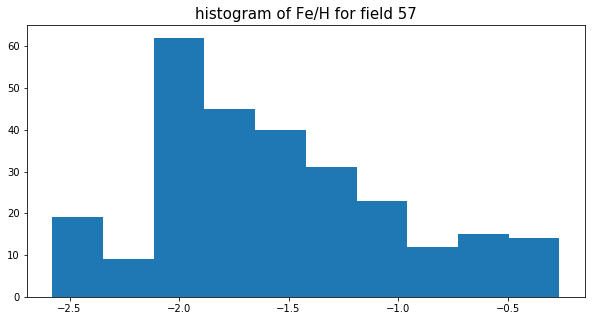

weighted mean using uerr:  -1.4227516154008633
weighted mean using gerr:  -1.5624207899576883
weighted mean using rerr:  -1.5536705389603904
metallicity for nearest method: -0.7632036209106445
metallicity for linear method: -1.6191887309839883
metallicity for cubic method: -2.2618775518582868
color median Fe/H for original method: -2.036130666732788
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.900514253653286
color median Fe/H for cubic method: -1.6507241187792334
metallicity for nearest neighbor regression method: -1.7778528
mean metallicity for ivezic equation method:  -1.7664945286356954
number of initial stars in field 58: 77341
number of stars after cuts in field 58: 788
metallicity for original method: -1.3805735785143354


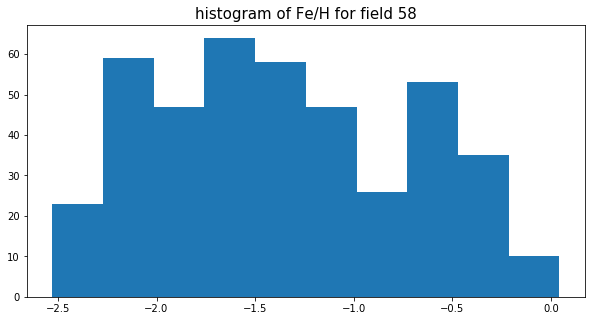

weighted mean using uerr:  -1.1018338384521065
weighted mean using gerr:  -1.5077036617425676
weighted mean using rerr:  -1.4723691028279124
metallicity for nearest method: -1.2061405658721924
metallicity for linear method: -1.457146051894976
metallicity for cubic method: -2.02449791146963
color median Fe/H for original method: -2.036130666732788
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.900514253653286
color median Fe/H for cubic method: -1.6507241187792334
metallicity for nearest neighbor regression method: -1.6371828
mean metallicity for ivezic equation method:  -1.6676941551908064
number of initial stars in field 59: 88849
number of stars after cuts in field 59: 2148
metallicity for original method: -1.4055117055179907


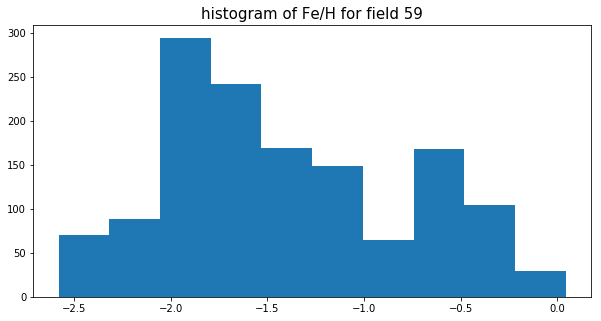

weighted mean using uerr:  -1.168619360528653
weighted mean using gerr:  -1.3961751523541917
weighted mean using rerr:  -0.3102047780627036
metallicity for nearest method: -1.096127740542094
metallicity for linear method: -1.4387011566556698
metallicity for cubic method: -1.8780588524925106
color median Fe/H for original method: -1.824390172958374
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.8671866534121997
color median Fe/H for cubic method: -1.9607130425756147
metallicity for nearest neighbor regression method: -1.5753149
mean metallicity for ivezic equation method:  -1.7121028798421378
number of initial stars in field 60: 59324
number of stars after cuts in field 60: 664
metallicity for original method: -1.7675879247147928


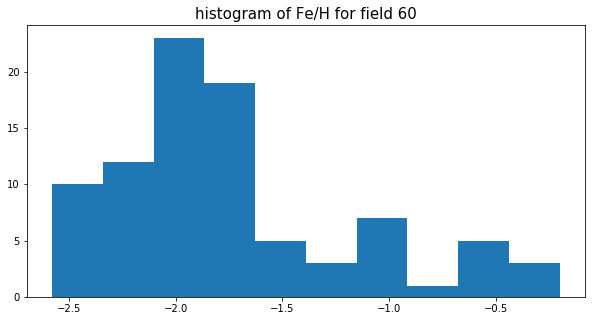

weighted mean using uerr:  -1.6841611015750073
weighted mean using gerr:  -1.7780122546013168
weighted mean using rerr:  -1.7723739021417921
metallicity for nearest method: -0.9724085330963135
metallicity for linear method: -1.816825810757855
metallicity for cubic method: -2.9802625326657473
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: nan
color median Fe/H for cubic method: nan
metallicity for nearest neighbor regression method: -1.9475253
mean metallicity for ivezic equation method:  -1.6638046386706764
number of initial stars in field 61: 80665
number of stars after cuts in field 61: 1745
metallicity for original method: -1.5234058129448276


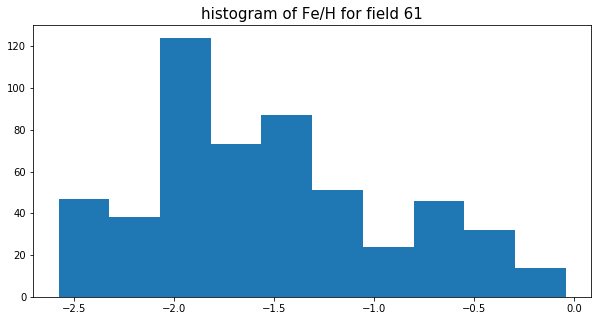

weighted mean using uerr:  -1.0746542375368187
weighted mean using gerr:  -1.5420402455378945
weighted mean using rerr:  -1.566942655958342
metallicity for nearest method: -1.173415400765159
metallicity for linear method: -1.6112446798482045
metallicity for cubic method: -2.5385657388314384
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.120358209774938
color median Fe/H for cubic method: -7.132377762609695
metallicity for nearest neighbor regression method: -1.8583332
mean metallicity for ivezic equation method:  -2.0253228774333087
number of initial stars in field 63: 113977
number of stars after cuts in field 63: 1575
metallicity for original method: -1.695961169728627


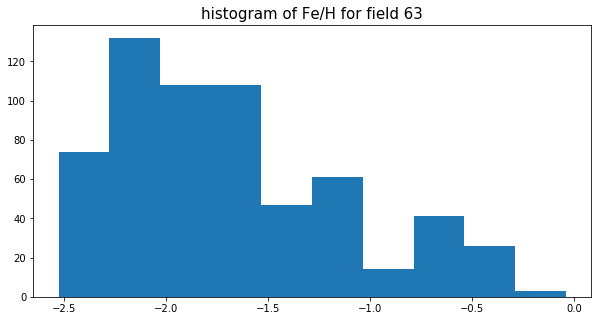

weighted mean using uerr:  -1.2940595873925034
weighted mean using gerr:  -1.0737152561007863
weighted mean using rerr:  -1.700558442292959
metallicity for nearest method: -1.0138885974884033
metallicity for linear method: -1.7981488027906134
metallicity for cubic method: -2.790974631717285
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.8966986132920074
color median Fe/H for cubic method: -1.720521376032387
metallicity for nearest neighbor regression method: -1.9645387
mean metallicity for ivezic equation method:  -2.264221218064994
number of initial stars in field 64: 68421
number of stars after cuts in field 64: 912
metallicity for original method: -1.5430704517160903


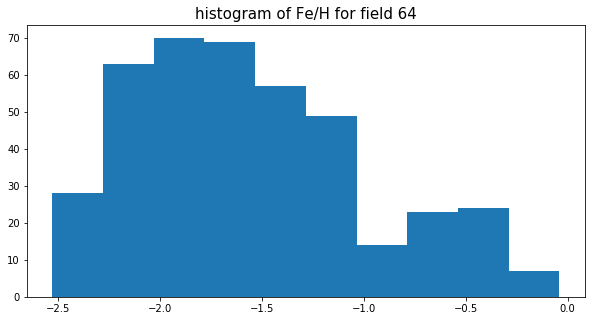

weighted mean using uerr:  -1.4062048462927466
weighted mean using gerr:  -1.5508492863217833
weighted mean using rerr:  -1.576596940447399
metallicity for nearest method: -0.9026735623677572
metallicity for linear method: -1.607717152042735
metallicity for cubic method: -2.252581651126935
color median Fe/H for original method: -2.005466938018799
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9809728105668718
color median Fe/H for cubic method: -1.9362052010283806
metallicity for nearest neighbor regression method: -1.8195348
mean metallicity for ivezic equation method:  -1.7676514044999316
number of initial stars in field 66: 101460
number of stars after cuts in field 66: 784
metallicity for original method: -1.3895764239853303


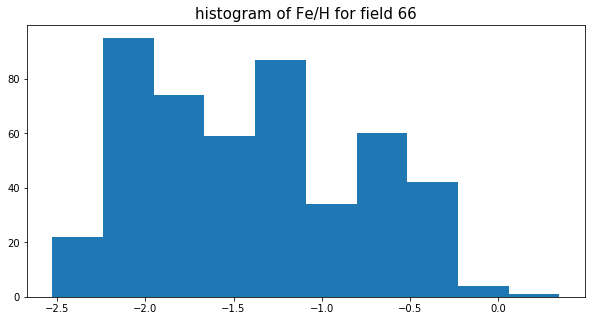

weighted mean using uerr:  -1.0658823634444201
weighted mean using gerr:  -1.5230621340246742
weighted mean using rerr:  -1.3423883347437306
metallicity for nearest method: -0.9657493554628812
metallicity for linear method: -1.45287454108856
metallicity for cubic method: -1.983958856799683
color median Fe/H for original method: -1.6655519008636475
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.725939633179567
color median Fe/H for cubic method: -1.7021761181674202
metallicity for nearest neighbor regression method: -1.5866373
mean metallicity for ivezic equation method:  -1.652407620568505
number of initial stars in field 68: 90704
number of stars after cuts in field 68: 689
metallicity for original method: -1.384896532297658


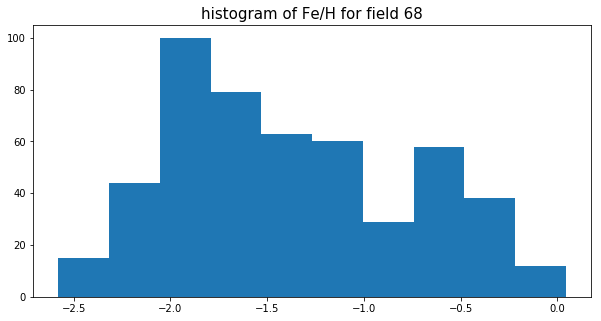

weighted mean using uerr:  -1.1375099815782128
weighted mean using gerr:  -1.424443389665519
weighted mean using rerr:  -1.4181874564368733
metallicity for nearest method: -1.1512114320482527
metallicity for linear method: -1.4137188955809852
metallicity for cubic method: -1.6473612926891468
color median Fe/H for original method: -1.6655519008636475
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.725939633179567
color median Fe/H for cubic method: -1.7021761181674202
metallicity for nearest neighbor regression method: -1.5297251
mean metallicity for ivezic equation method:  -1.3865277545378205
number of initial stars in field 149: 69283
number of stars after cuts in field 149: 616
metallicity for original method: -1.4363369404030988


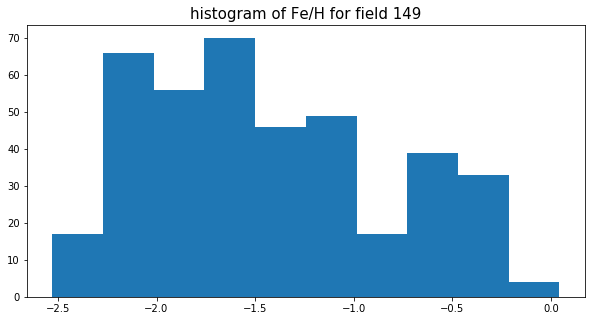

weighted mean using uerr:  -1.2875027759461743
weighted mean using gerr:  -1.7888826726926728
weighted mean using rerr:  -1.4215501666065526
metallicity for nearest method: -0.7632036209106445
metallicity for linear method: -1.4815925293964811
metallicity for cubic method: -1.734668849472925
color median Fe/H for original method: -1.9125463962554932
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9150277003104201
color median Fe/H for cubic method: -1.8688022871453192
metallicity for nearest neighbor regression method: -1.537908
mean metallicity for ivezic equation method:  -1.7919288395588124
number of initial stars in field 150: 46060
number of stars after cuts in field 150: 343
metallicity for original method: -1.497323318315086


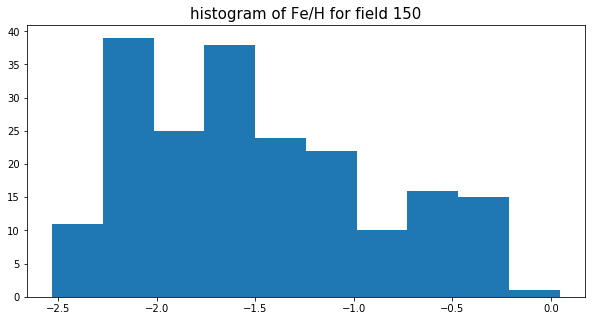

weighted mean using uerr:  -1.0225147309150842
weighted mean using gerr:  -1.4661022710112352
weighted mean using rerr:  -1.4056130931422097
metallicity for nearest method: -1.3270711217607771
metallicity for linear method: -1.5262597002510894
metallicity for cubic method: -1.9981518967118543
color median Fe/H for original method: -1.824390172958374
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.8671866534121997
color median Fe/H for cubic method: -1.9607130425756147
metallicity for nearest neighbor regression method: -1.6319252
mean metallicity for ivezic equation method:  -1.771454951152254
number of initial stars in field 156: 122018
number of stars after cuts in field 156: 636
metallicity for original method: -1.280798856549316


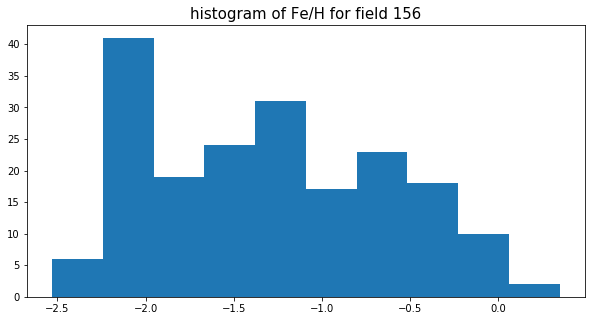

weighted mean using uerr:  -0.7156624127134866
weighted mean using gerr:  -1.247042238164128
weighted mean using rerr:  -1.177993930447206
metallicity for nearest method: -1.1350830793380737
metallicity for linear method: -1.4034030389056613
metallicity for cubic method: -2.071533889687346
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.120358209774938
color median Fe/H for cubic method: -7.132377762609695
metallicity for nearest neighbor regression method: -1.7279106
mean metallicity for ivezic equation method:  -0.25097107259186685
number of initial stars in field 176: 111318
number of stars after cuts in field 176: 10154
metallicity for original method: -1.4175882956640549


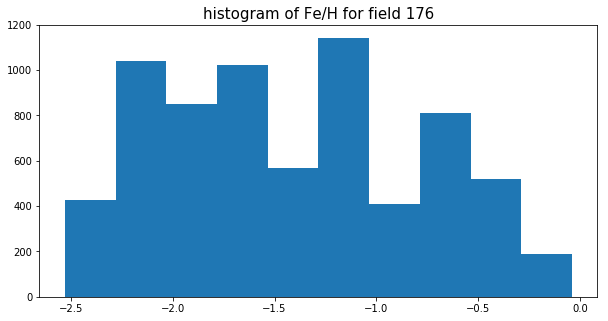

weighted mean using uerr:  -1.2485788144185879
weighted mean using gerr:  -1.4099490285718674
weighted mean using rerr:  -1.4731667505928965
metallicity for nearest method: -1.023698109759098
metallicity for linear method: -1.4941650987369566
metallicity for cubic method: -1.7196697082738244
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.5682153
mean metallicity for ivezic equation method:  -1.7488675754768899
number of initial stars in field 177: 98553
number of stars after cuts in field 177: 2870
metallicity for original method: -1.344580028331758


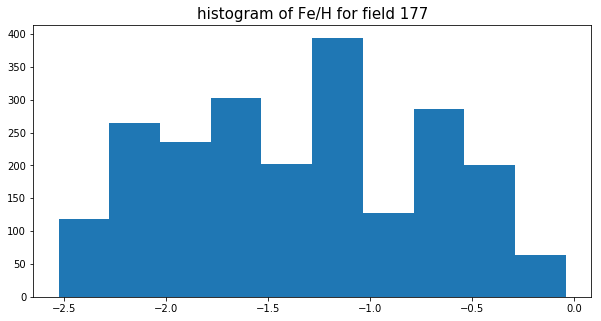

weighted mean using uerr:  -1.184774916036212
weighted mean using gerr:  -1.3786229967308652
weighted mean using rerr:  -2.096336583360411
metallicity for nearest method: -0.9249090353647867
metallicity for linear method: -1.3958305076997513
metallicity for cubic method: -1.4808833771086836
color median Fe/H for original method: -1.132754921913147
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.1726204685937023
color median Fe/H for cubic method: -1.1018151569994665
metallicity for nearest neighbor regression method: -1.4378991
mean metallicity for ivezic equation method:  -1.592598173593373
number of initial stars in field 178: 233226
number of stars after cuts in field 178: 26378
metallicity for original method: -1.3907774851260726


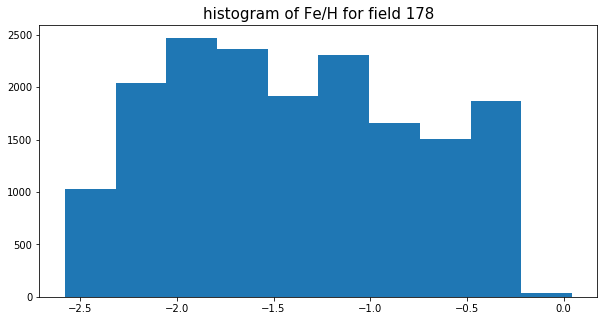

weighted mean using uerr:  -1.2309113433018037
weighted mean using gerr:  -1.3861913446075669
weighted mean using rerr:  -1.3677080024094936
metallicity for nearest method: -1.0774056950110091
metallicity for linear method: -1.4766756934870615
metallicity for cubic method: -1.7266995819764581
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
metallicity for nearest neighbor regression method: -1.5490432
mean metallicity for ivezic equation method:  -1.7410511069204613
number of initial stars in field 246: 76714
number of stars after cuts in field 246: 21
metallicity for original method: nan


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


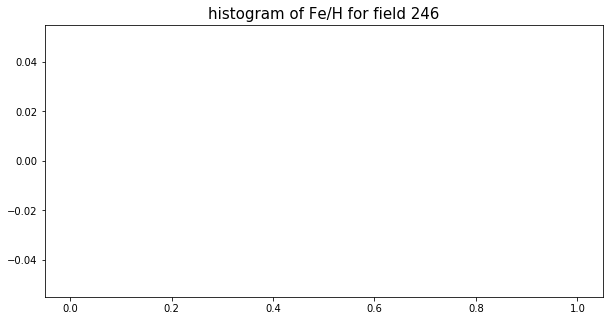

weighted mean using uerr:  nan
weighted mean using gerr:  nan
weighted mean using rerr:  nan
metallicity for nearest method: nan
metallicity for linear method: nan
metallicity for cubic method: nan
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: nan
color median Fe/H for cubic method: nan
metallicity for nearest neighbor regression method: -2.0351875
mean metallicity for ivezic equation method:  4.6393302133831105


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
if __name__=="__main__":
    for number in fields:
        metallicity('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

              

In [12]:
#ra and dec of each SMASH field and of the centers of LMC/SMC
ra = np.array([2.58282, 4.74128, 5.8295, 6.23604, 11.0282, 11.2637, 12.6438, 15.3642, 17.2959, 19.3929, 20.1116, 21.1397, 22.3556, 32.3014, 33.2987, 33.7735, 38.0154, 40.8729, 48.7252, 55.0714, 62.0399, 62.2076, 71.5224, 72.8794, 73.2326, 73.826, 74.3797, 74.8251, 75.6417, 78.0543, 79.5644, 81.6974, 83.023, 84.5087, 85.416, 87.2541, 87.3605, 89.5211, 96.3535, 96.7494, 98.0372, 98.2317, 107.298, 108.637, 111.26, 111.286, 114.087, 114.673, 118.049, 120.112, 128.154, 130.919, 351.667, 351.815, 115.38663, 10.65102, 22.45883, 25.12044, 101.835])
dec = np.array([-69.7946, -77.0834, -73.9689, -72.3856, -71.6294, -74.8041, -82.474, -70.7182, -75.4505, -78.5112, -71.2591, -72.825, -74.3674, -73.2717, -77.5124, -67.4354, -70.2838, -74.5334, -72.4893, -76.4147, -72.0384, -68.4171, -75.3739, -68.7777, -80.7479, -70.5799, -84.3086, -72.3767, -67.5258, -66.2141, -72.8687, -66.6022, -76.3886, -73.2367, -66.8939, -71.7809, -68.5956, -70.2803, -79.9982, -67.1805, -75.1855, -70.3668, -68.3137, -54.6223, -59.3505, -64.5201, -76.1913, -70.9916, -67.0089, -84.4426, -72.6595, -76.0996, -72.0863, -67.6899, -54.888583, -67.7937, -67.39283, -71.2175, -52.264999])
#associated SkyCoord object
c_fields = SkyCoord(ra,dec,unit='deg')

#LMC center
ra_lmc = 81.900000
dec_lmc = -69.866667
#SMC center
ra_smc = 13.183333
dec_smc = -72.828333
#associated SkyCoord objects
c_lmc = SkyCoord(ra_lmc,dec_lmc,unit='deg')
c_smc = SkyCoord(ra_smc,dec_smc,unit='deg')

#calculate radii from LMC/SMC center
radii_lmc = c_fields.separation(c_lmc)
radii_smc = c_fields.separation(c_smc)


In [13]:
radii_lmc = radii_lmc.degree
radii_smc = radii_smc.degree

In [14]:
lmc_fields = [156,24,246,26,27,28,29,31,33,44,52,53,54,55,56,57,58,59,60,61,63,64,66,68,30,32,34,35,37,40,42,46,48,49,50,51]


In [15]:
lmc_index = []
for i in np.arange(0,len(fields)):
    for j in lmc_fields:
        if fields[i]==j:
            lmc_index.append(i)

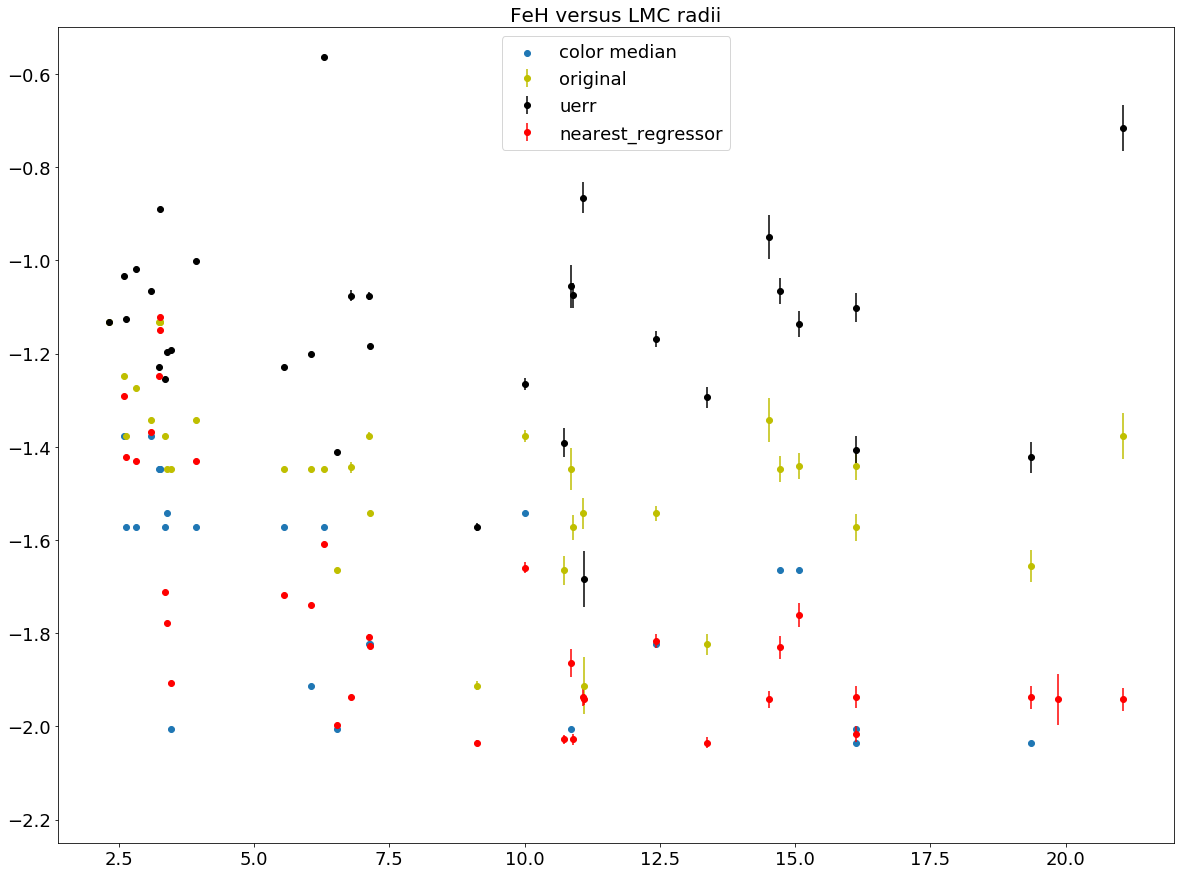

In [16]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','r','b','g','c','m']
#for i, method in enumerate(('original','nearest_regressor','uerr','gerr','rerr')):
for i, method in enumerate(('original','uerr','nearest_regressor')):
    ax.errorbar(radii_lmc[lmc_index],np.array(metal[method])[lmc_index],yerr=np.array(error[method])[lmc_index],fmt='o',c=colors[i],label=method)

ax.scatter(radii_lmc[lmc_index],np.array(color['original'])[lmc_index],label='color median')  
ax.set_title('FeH versus LMC radii',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim(-2.25,-.5)
ax.legend(fontsize=18)
    

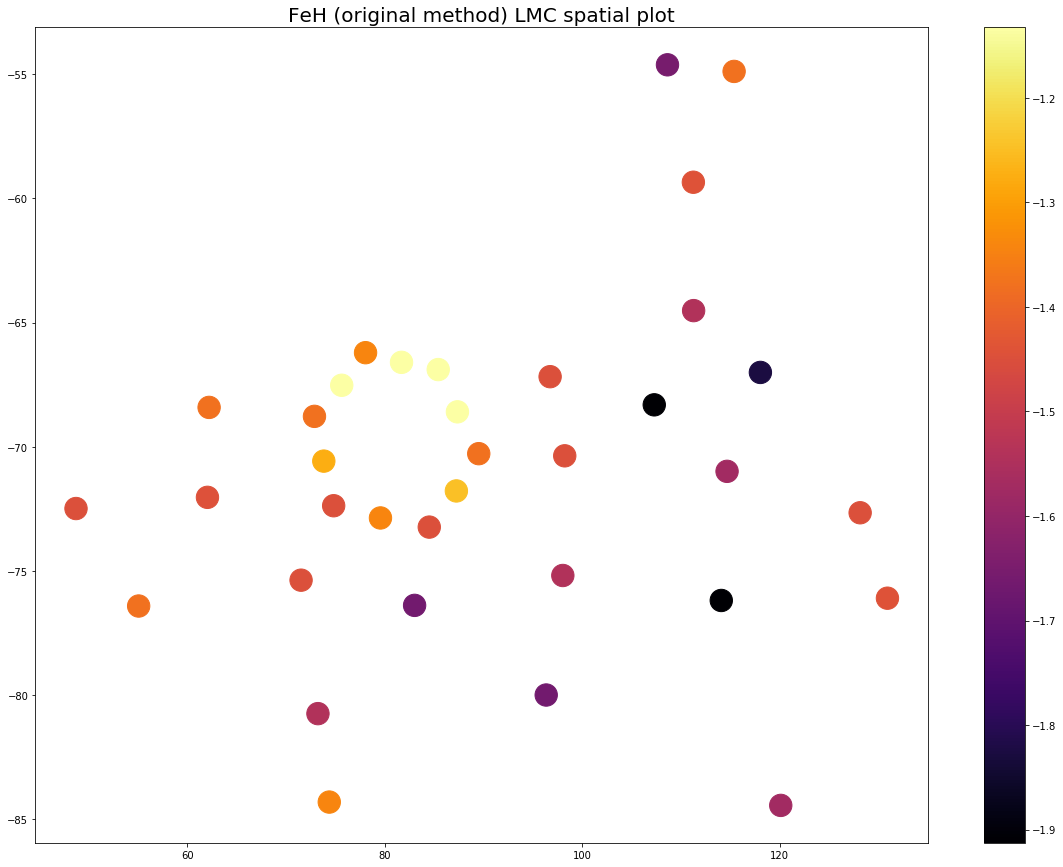

In [17]:
#LMC spatial plot with Fe/H
fig, ax = plt.subplots(figsize=(20,15))
im=ax.scatter(ra[lmc_index],dec[lmc_index],c=np.array(metal['original'])[lmc_index],s=500,cmap='inferno')
ax.set_title('FeH (original method) LMC spatial plot',fontsize=20)
fig.colorbar(im)



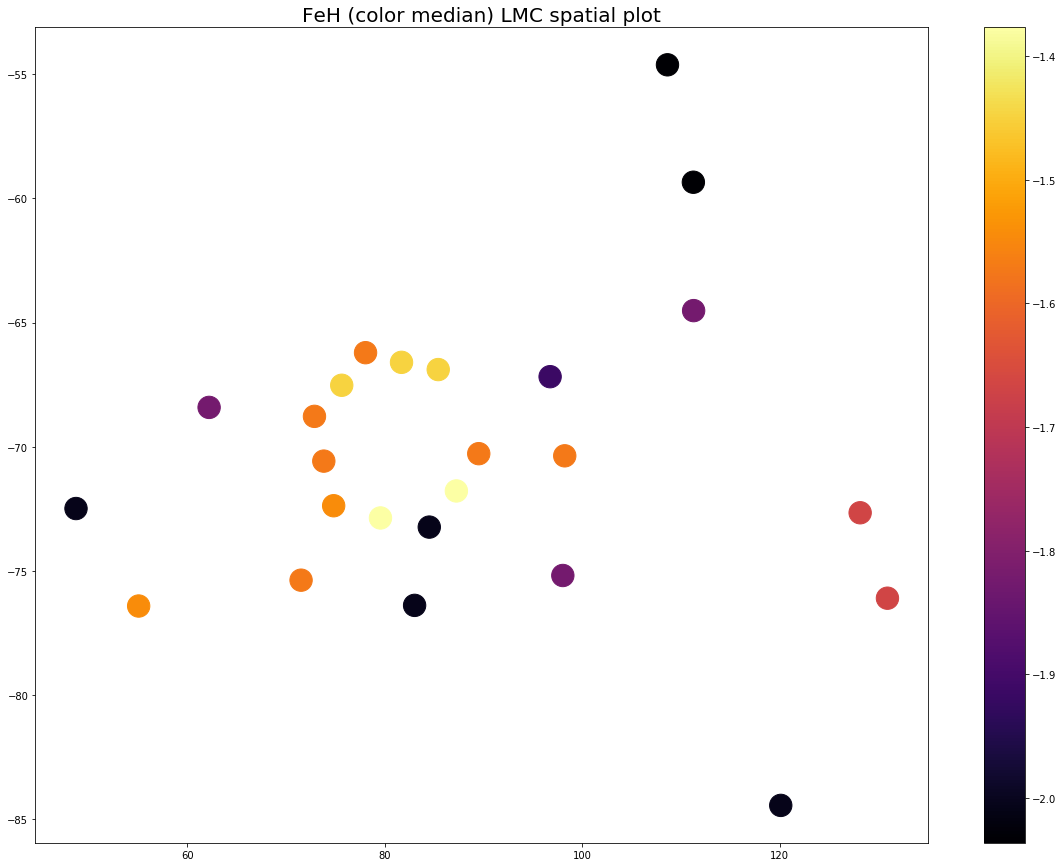

In [18]:
#LMC spatial plot with Fe/H
fig, ax = plt.subplots(figsize=(20,15))
im=ax.scatter(ra[lmc_index],dec[lmc_index],c=np.array(color['original'])[lmc_index],s=500,cmap='inferno')
ax.set_title('FeH (color median) LMC spatial plot',fontsize=20)
fig.colorbar(im)


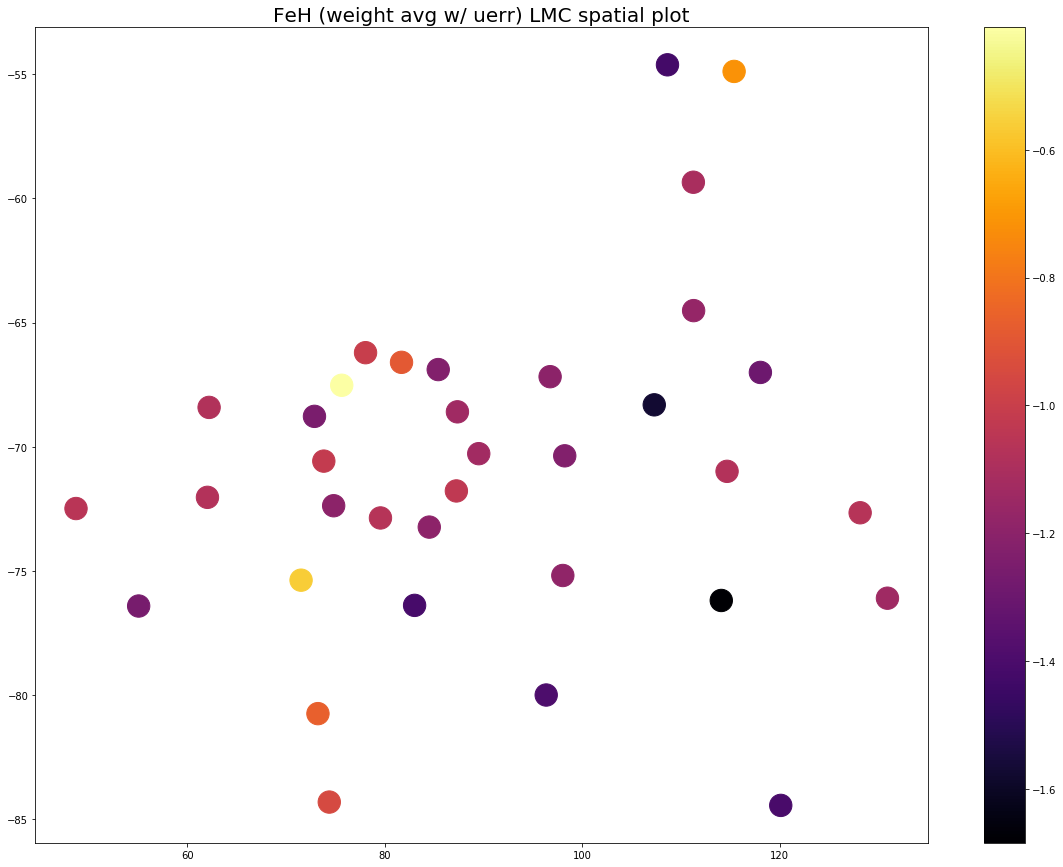

In [19]:
#LMC spatial plot with Fe/H
fig, ax = plt.subplots(figsize=(20,15))
im=ax.scatter(ra[lmc_index],dec[lmc_index],c=np.array(metal['uerr'])[lmc_index],s=500,cmap='inferno')
ax.set_title('FeH (weight avg w/ uerr) LMC spatial plot',fontsize=20)
fig.colorbar(im)



In [20]:
smc_fields = [1,13,149,150,176,177,178,18,20,21,22,8,12,14,15,16,19,2,3,4,5,7,9]

In [22]:
smc_index = []
for i in np.arange(0,len(fields)):
    for j in smc_fields:
        if fields[i]==j:
            smc_index.append(i)

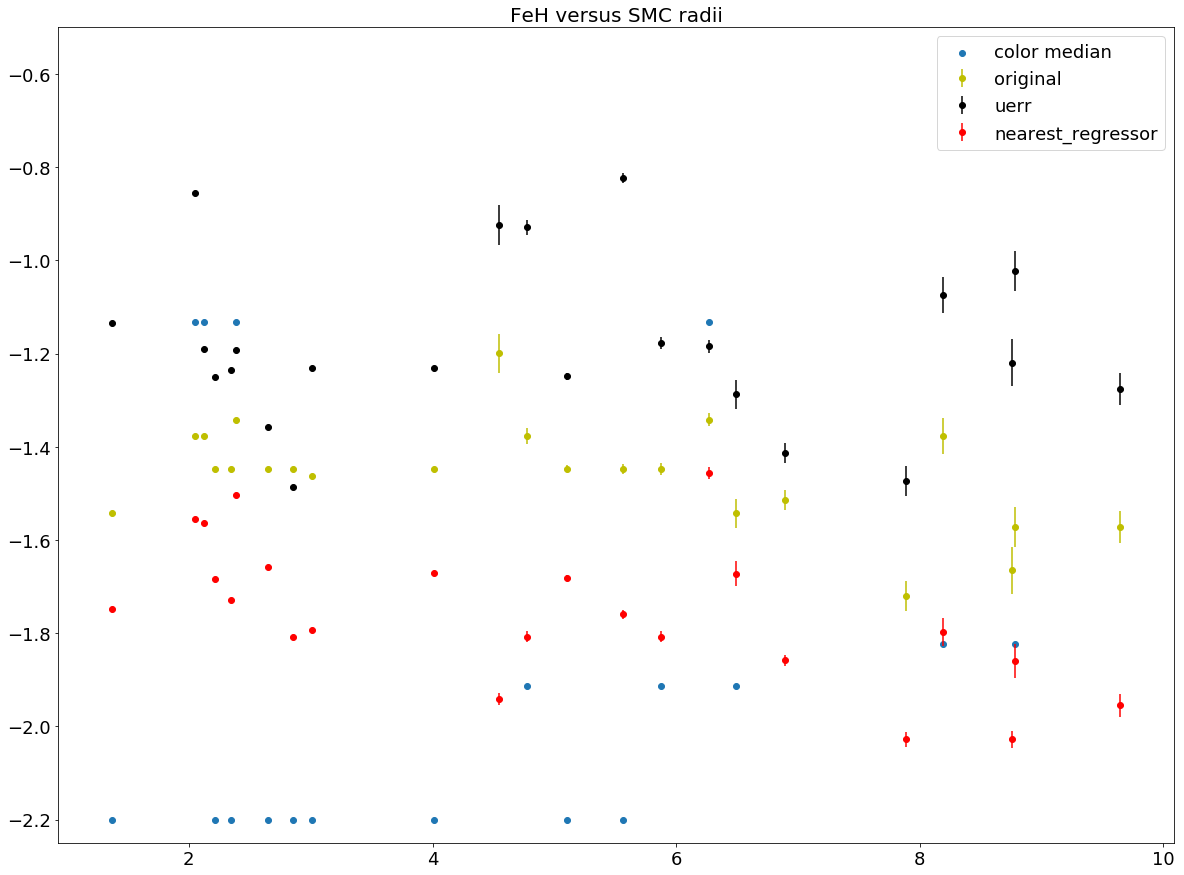

In [23]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','r','b','g','c','m']
#for i, method in enumerate(('original','nearest_regressor','uerr','gerr','rerr')):
for i, method in enumerate(('original','uerr','nearest_regressor')):
    ax.errorbar(radii_smc[smc_index],np.array(metal[method])[smc_index],yerr=np.array(error[method])[smc_index],fmt='o',c=colors[i],label=method)

ax.scatter(radii_smc[smc_index],np.array(color['original'])[smc_index],label='color median')  
ax.set_title('FeH versus SMC radii',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim(-2.25,-.5)
ax.legend(fontsize=18)
    

(0, 50)

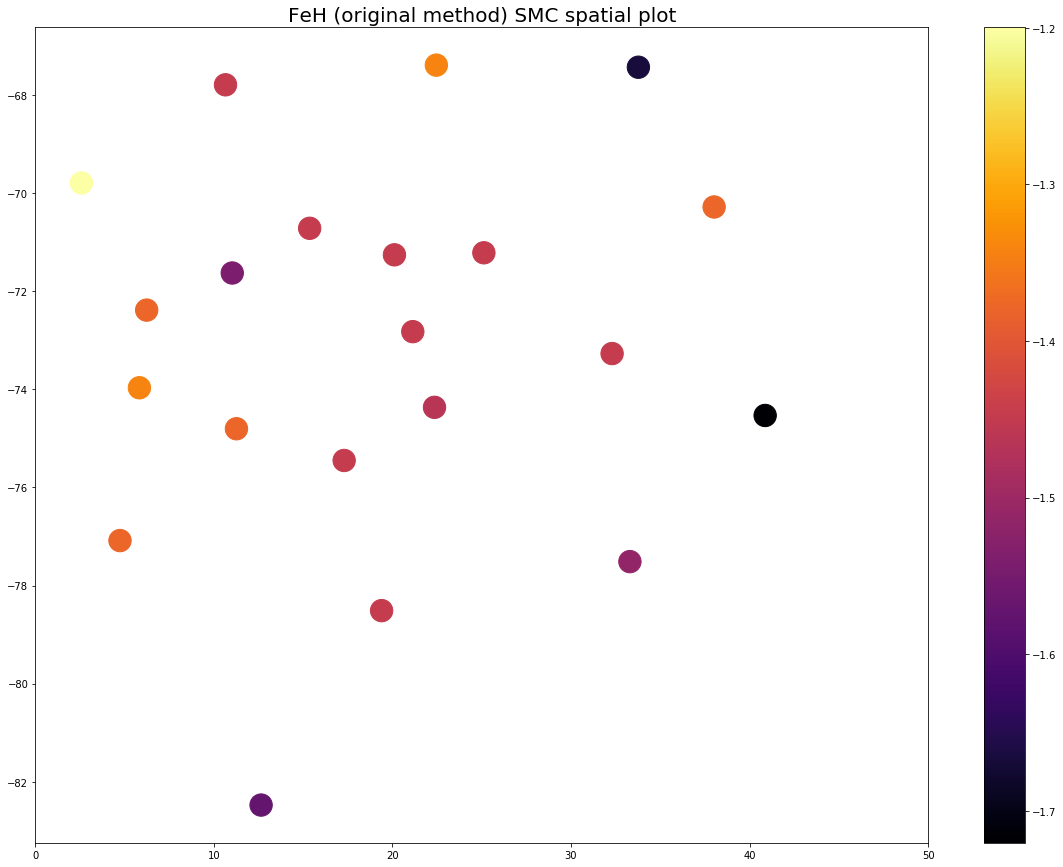

In [24]:
#SMC spatial plot with Fe/H
fig, ax = plt.subplots(figsize=(20,15))
im=ax.scatter(ra[smc_index],dec[smc_index],c=np.array(metal['original'])[smc_index],s=500,cmap='inferno')
ax.set_title('FeH (original method) SMC spatial plot',fontsize=20)
fig.colorbar(im)
ax.set_xlim(0,50)



(0, 50)

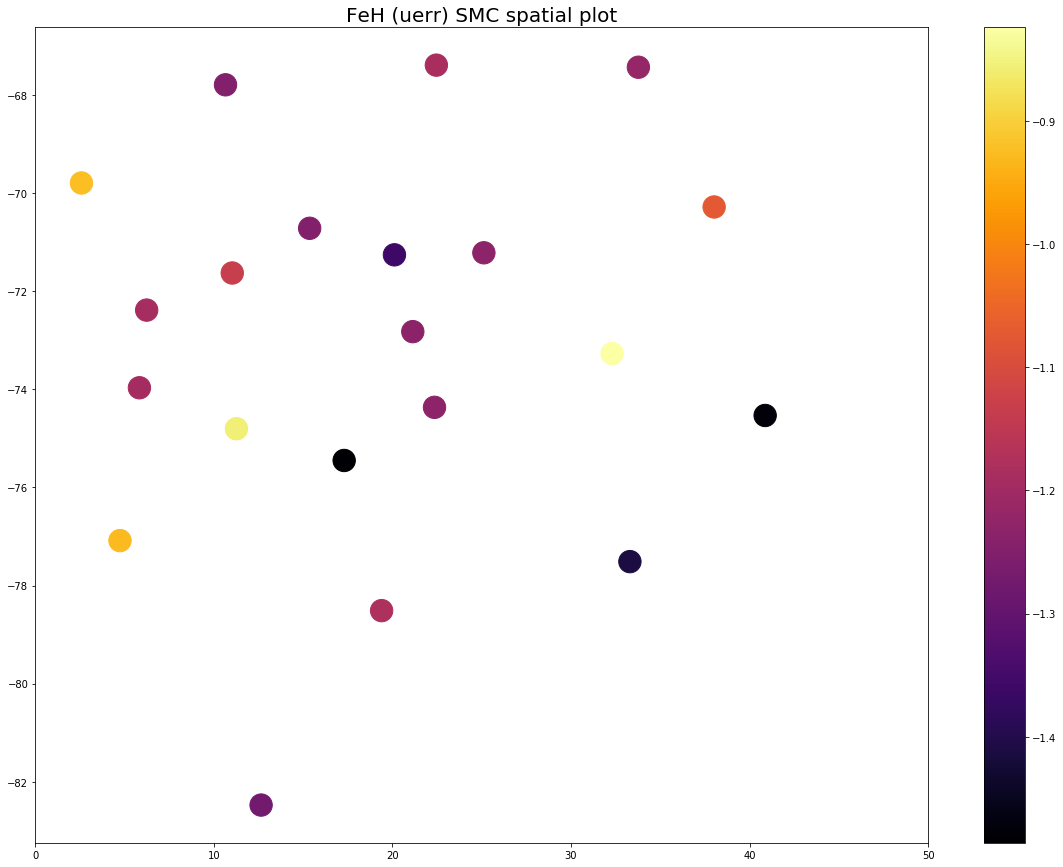

In [25]:
#SMC spatial plot with Fe/H
fig, ax = plt.subplots(figsize=(20,15))
im=ax.scatter(ra[smc_index],dec[smc_index],c=np.array(metal['uerr'])[smc_index],s=500,cmap='inferno')
ax.set_title('FeH (uerr) SMC spatial plot',fontsize=20)
fig.colorbar(im)
ax.set_xlim(0,50)



In [26]:
#make histograms of data

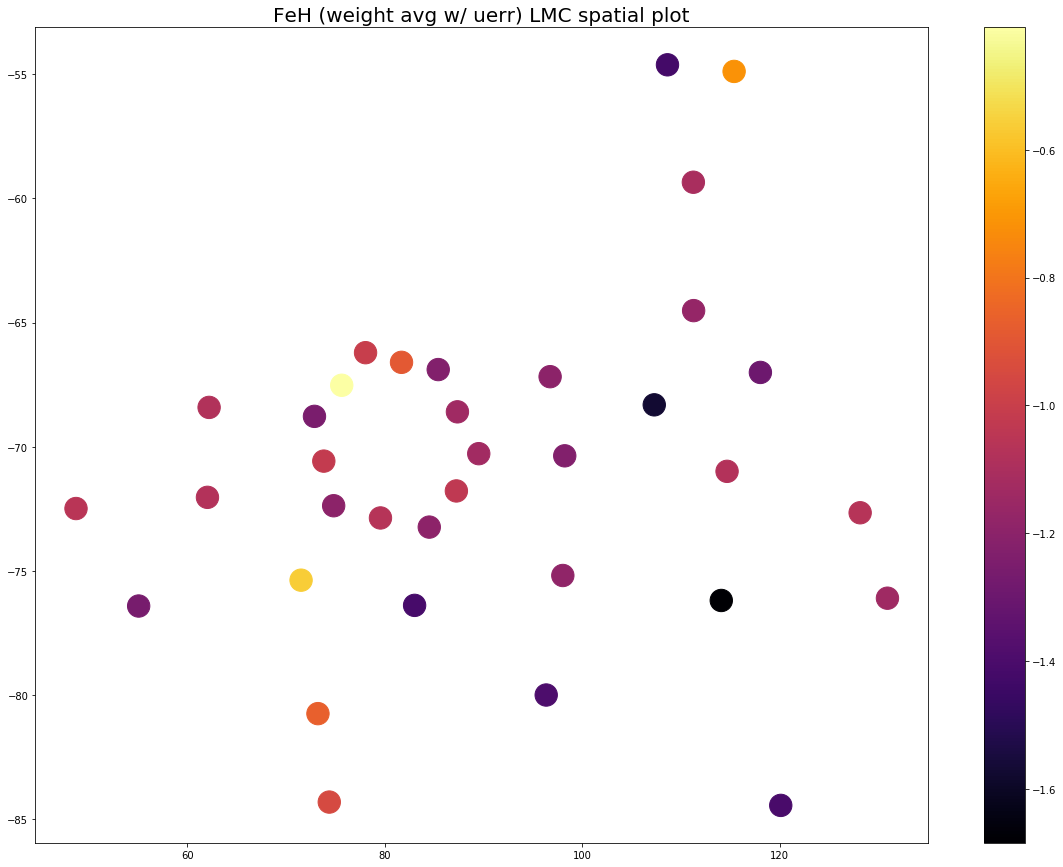

In [28]:
#LMC spatial plot with Fe/H
fig, ax = plt.subplots(figsize=(20,15))
im=ax.scatter(ra[lmc_index],dec[lmc_index],c=np.array(metal['uerr'])[lmc_index],s=500,cmap='inferno')
ax.set_title('FeH (weight avg w/ uerr) LMC spatial plot',fontsize=20)
fig.colorbar(im)



In [29]:
from scipy.stats import kde
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [30]:

objs = fx[1].read()
u_std = (objs["U"]-(4.239*objs["EBV"]))
g_std = (objs["G"]-(3.303*objs["EBV"]))
i_std = (objs["I"]-(1.263*objs["EBV"]))
r_std = (objs["R"]-(2.285*objs["EBV"]))
u_g_std = u_std - g_std
g_r_std = g_std - r_std
selected = np.where((u_std<=30)&(r_std<=30)&(g_std<=30))
u_std,g_std,r_std = u_std[selected],g_std[selected],r_std[selected]


In [31]:
xx_std, yy_std = np.mgrid[u_g_std.min():u_g_std.max():1000j, g_r_std.min():g_r_std.max():1000j]
positions = np.vstack([xx_std.ravel(), yy_std.ravel()])
values = np.vstack([u_g_std, g_r_std])
k_std = kde.gaussian_kde(values)

In [32]:
zz_std = np.reshape(k_std(positions).T, xx_std.shape)

In [33]:
import matplotlib.colors as clr

In [34]:
 def density_plots(filename):
    
    fx = fitsio.FITS(filename)
    objs = fx[1].read()
    
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    u = (objs["U"]-(4.239*objs["EBV"]))
    g = (objs["G"]-(3.303*objs["EBV"]))
    i = (objs["I"]-(1.263*objs["EBV"]))
    r = (objs["R"]-(2.285*objs["EBV"]))
    selected = np.where((u<=30)&(r<=30)&(g<=30)&(i<=30)&(objs['CHI']<3)&(abs(objs['SHARP'])<1)&(objs['PROB']>.8))
    u,g,r,i = u[selected],g[selected],r[selected],i[selected]
    u_g = u-g
    g_r = g-r
    g_i = g-i
    
    fig, ax = plt.subplots(figsize=(10,5))
    hess = stats.binned_statistic_2d(u_g, g_r, None, 'count',bins=1000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    ax.contour(xx_std,yy_std,zz_std,cmap='spring')
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    ax.set_xlabel('u-g')
    ax.set_ylabel('g-r')
    ax.set_title('Density Plot of SMASH Field '+str(field_number[0])+' with Contours of SMASH Calibration Data Overlaid')
    
    plt.show(block=False)
    
    fig, ax = plt.subplots(figsize=(10,5))
    hess = stats.binned_statistic_2d(g_i,g, None, 'count',bins=1000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-2,2)
    ax.set_xlabel('g-i')
    ax.set_ylabel('g')
    ax.invert_yaxis()
    print('done with field '+str(field_number))
    return 0


<IPython.core.display.Javascript object>


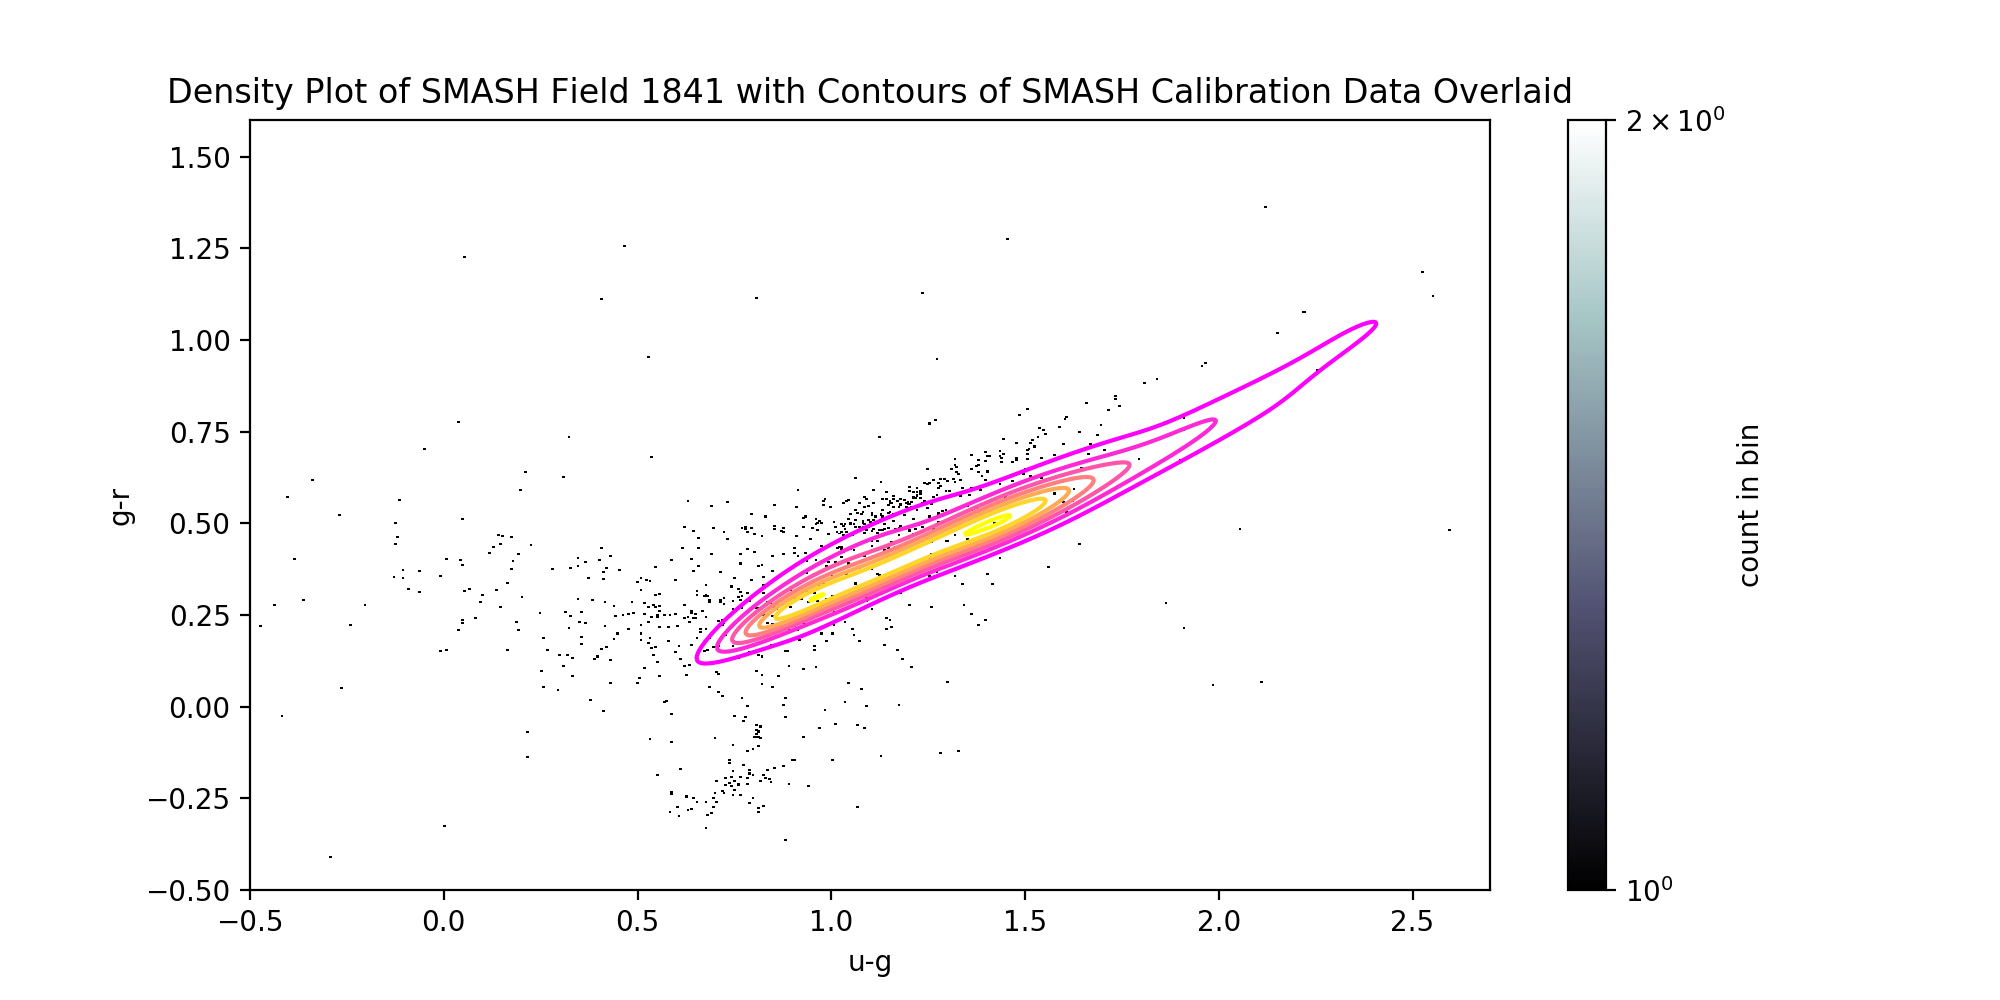

/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


<IPython.core.display.Javascript object>


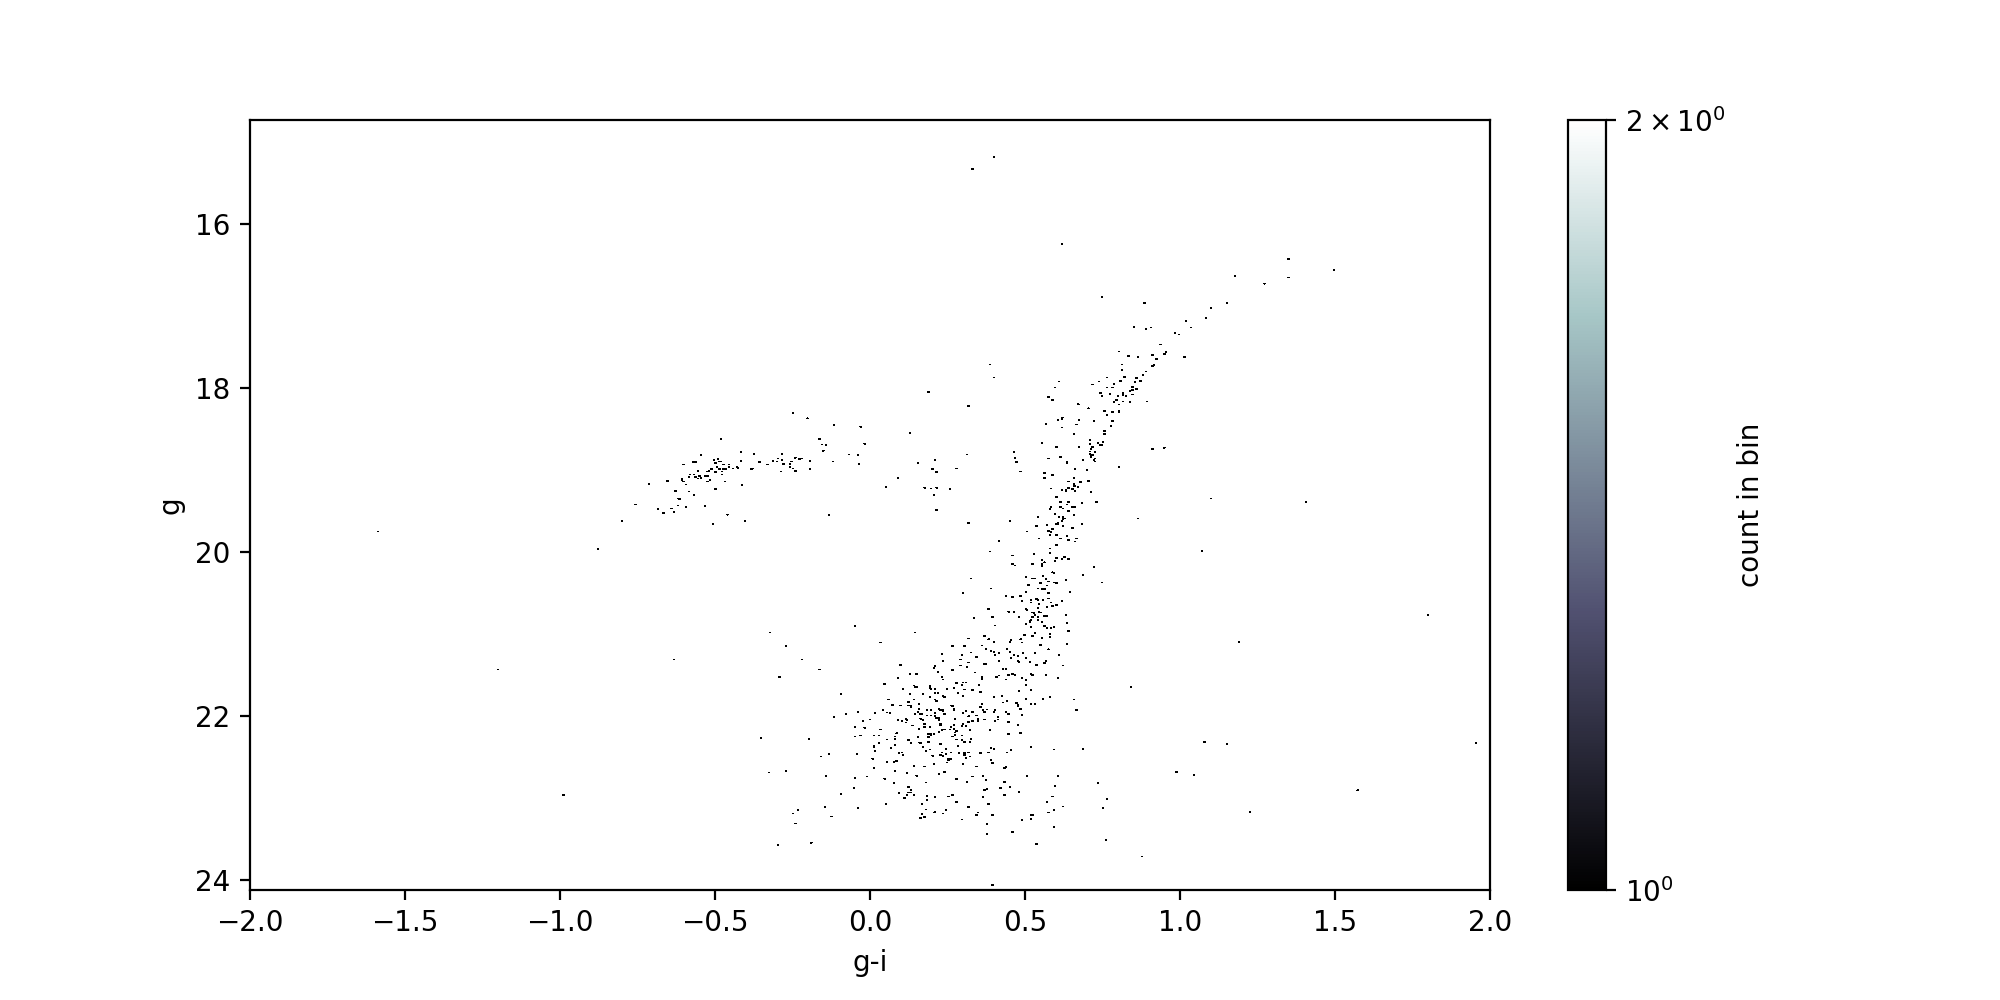

done with field [1841]


In [35]:
%matplotlib notebook
if __name__=="__main__":
    density_plots('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

              

In [36]:
#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    #initial_stars.append(objs_new)
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    #selected = np.where(((g-r)>=0.104)&((g-r)<=1.125)&((g-r)>=0.644)&((g-r)<=2.37)&(g<=30)&(u<=30)&(r<=30)&(i<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    #selected = np.where(((g<=30)&(u<=30)&(r<=30)&(i<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8)))
    selected = np.where(((g-i)>=0.02)&((g-i)<=0.65)&((g)>=18.95)&((g)<=22.26)&(g<=30)&(u<=30)&(r<=30)&(i<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    #weights to compute weighted average
    wt_uerr = 1/(uerr**2)
    wt_gerr = 1/(gerr**2)
    wt_rerr = 1/(rerr**2)
    wts = [wt_uerr,wt_gerr,wt_rerr]
    
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    #cut_stars.append(len(u))
    stars = len(u)
    
    #original metallicity values from binned_statistic_sd from original calibration sample 
    ind, = np.where(((u_g)>=xedge['original'].min())&((u_g)<=xedge['original'].max())&((g_r)>=yedge['original'].min())&((g_r)<=yedge['original'].max()))
    ix = np.searchsorted(xedge['original'],(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge['original'],(g_r)[ind])
    iy = iy - 1
    feh = ret['original'][ix,iy]
    N = np.count_nonzero(~np.isnan(feh))
    #mean_metallicity['original'].append(np.nanmean(feh))
    #print("mean metallicity for original method:",(np.nanmean(feh)))
    #median_metallicity['original'].append(np.nanmedian(feh))
    print("median metallicity for original method:",(np.nanmedian(feh)))
    #std['original'].append(np.nanstd(feh))
    #error['original'].append((np.nanstd(feh))/np.sqrt(N))

    #weighted averages computed using error in the u, g, and r bands
    for i, method in enumerate(('uerr','gerr','rerr')):
        wt = 1/(wts[i]**2)
        wt = wt[ind]
        selected = np.where((np.isnan(feh)!=True))
        feh = feh[selected]
        N = np.count_nonzero(~np.isnan(feh))
        wt = wt[selected]
        #mean_metallicity[method].append((np.sum(wt*feh))/(np.sum(wt)))
        #std[method].append(np.nanstd(feh))
        #error[method].append((np.nanstd(feh))/np.sqrt(N))
        print("weighted mean using "+str(method)+': ',((np.sum(wt*feh))/(np.sum(wt))))    
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        N = np.count_nonzero(~np.isnan(feh))
        #mean_metallicity[method].append(np.nanmean(feh))
        #median_metallicity[method].append(np.nanmedian(feh))
        print("mean metallicity for "+method+" method:",(np.nanmean(feh)))
        #std[method].append(np.nanstd(feh))
        #error[method].append((np.nanstd(feh))/np.sqrt(N))
        
    #compute mean/median colors inside field, and then metallicity
    for i, method in enumerate(('original','nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        mean_u_g = np.nanmean(u_g[ind])
        mean_g_r = np.nanmean(g_r[ind])
        ix = np.searchsorted(xedge[method],mean_u_g)
        ix = ix - 1
        iy = np.searchsorted(yedge[method],mean_g_r)
        iy = iy - 1
        feh = ret[method][ix,iy]
        #color_mean[method].append(np.nanmean(feh))
        print("color mean Fe/H for "+method+" method:",(np.nanmean(feh)))
    
    for i, method in enumerate(('original','nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        median_u_g = np.nanmedian(u_g[ind])
        median_g_r = np.nanmedian(g_r[ind])
        ix = np.searchsorted(xedge[method],median_u_g)
        ix = ix - 1
        iy = np.searchsorted(yedge[method],median_g_r)
        iy = iy - 1
        feh = ret[method][ix,iy]
        #color_median[method].append(np.nanmedian(feh))
        print("color median Fe/H for "+method+" method:",(np.nanmedian(feh)))
        
    #use machine learning algorithm Nearest Neighbors
    ###The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.
    sample = np.reshape(np.ravel([u_g,g_r],order='F'),(len(u_g),2))   
    knn = neighbors.KNeighborsRegressor(5,weights='uniform')
    feh = knn.fit(points,feh_cal).predict(sample)
    #mean_metallicity['nearest_regressor'].append(np.nanmean(feh))
    #median_metallicity['nearest_regressor'].append(np.nanmedian(feh))
    print("mean metallicity for nearest neighbor regression method:",(np.nanmean(feh)))
    #std['nearest_regressor'].append(np.nanstd(feh))
    #error['nearest_regressor'].append((np.nanstd(feh))/np.sqrt(stars))
    
    #use equation (4) from Ivezic et al. 2008 to estimate metallicity
    ### x=(u-g) for (g-r)<=0.4; x=(u-g)-2(g-r)+0.8 for (g-r)>0.4
    ### y=(g-r)
    feh = []
    x = u_g -(2*g_r) + 0.8
    index = np.arange(0,len(u_g))
    
    for i in index:
        feh.append([ivezic_equation(u_g[i],g_r[i]) if g_r[i] <= 0.4 else ivezic_equation(x[i],g_r[i])])
    #feh.append(ivezic_equation(u_g[i],g_r[i]))
    
    N = np.count_nonzero(~np.isnan(feh))
    #mean_metallicity['ivezic'].append(np.nanmean(feh))
    #median_metallicity['ivezic'].append(np.nanmedian(feh))
    #std['ivezic'].append(np.nanstd(feh))
    #error['ivezic'].append((np.nanstd(feh))/np.sqrt(N))
    print('mean metallicity for ivezic equation method: ',(np.nanmean(feh)))
    
    return 0


In [37]:
if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')
    

number of initial stars in field 1841: 3405
number of stars after cuts in field 1841: 391
median metallicity for original method: -1.5525517463684082
weighted mean using uerr:  -0.9228513079244708
weighted mean using gerr:  -1.3381680000693337
weighted mean using rerr:  -1.4522599543189934
mean metallicity for nearest method: -1.1671852270762126
mean metallicity for linear method: -1.4772487646912935
mean metallicity for cubic method: -1.7436811858169914
color mean Fe/H for original method: -1.8251855373382568
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: -1.7256381755110088
color mean Fe/H for cubic method: -1.7294615377685405
color median Fe/H for original method: -1.342668056488037
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.4204809950880892
color median Fe/H for cubic method: -1.3861926802405522
mean metallicity for nearest neighbor regression method: -1.6104748
mean metallicity for ivezic equation method:  0.088587

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


### literature value for NGC 1841: -2.02
### median Fe/H w/ no selection box: -1.62
### median Fe/H w/ same selection box: -1.39